In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
0    4684
5    4684
3    4684
6    4684
8    4684
1    4684
2    4684
4    4684
7    4684
9    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


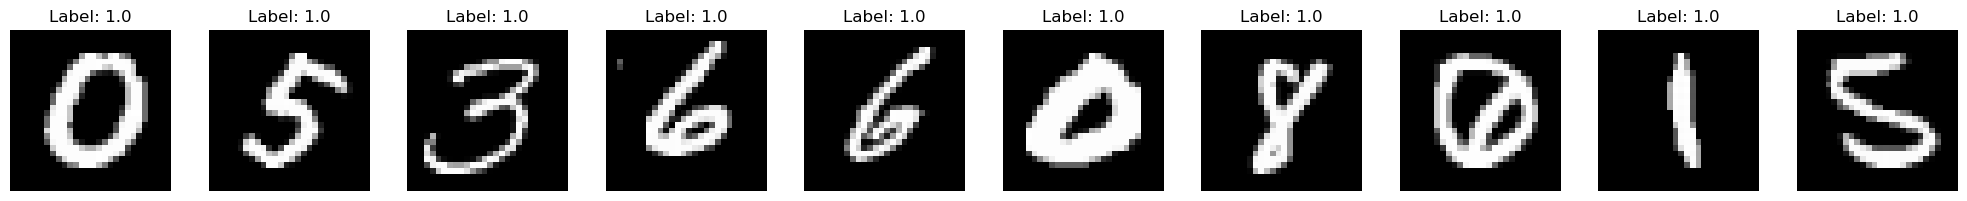

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.64it/s, loss_D=1.27, loss_G=0.738]


Epoch [1/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [1/200] - Average D loss: 1.3143, Average G loss: 0.7553


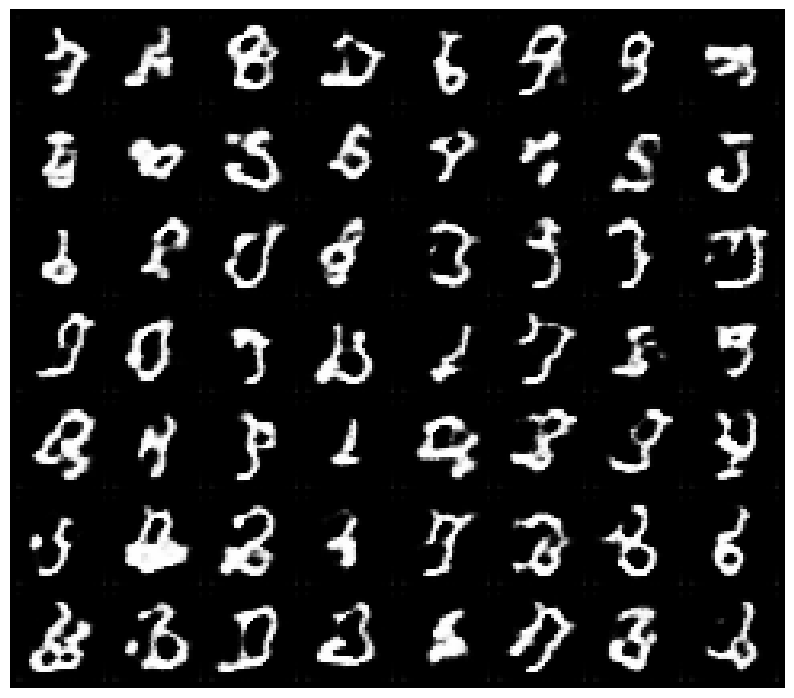

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.22it/s, loss_D=1.23, loss_G=0.917]


Epoch [2/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [2/200] - Average D loss: 1.2921, Average G loss: 0.7895


100%|█████████████████████████████████████████████████████| 732/732 [00:21<00:00, 33.35it/s, loss_D=1.17, loss_G=0.909]


Epoch [3/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [3/200] - Average D loss: 1.2443, Average G loss: 0.8542


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.12it/s, loss_D=1.2, loss_G=0.897]


Epoch [4/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [4/200] - Average D loss: 1.2246, Average G loss: 0.8889


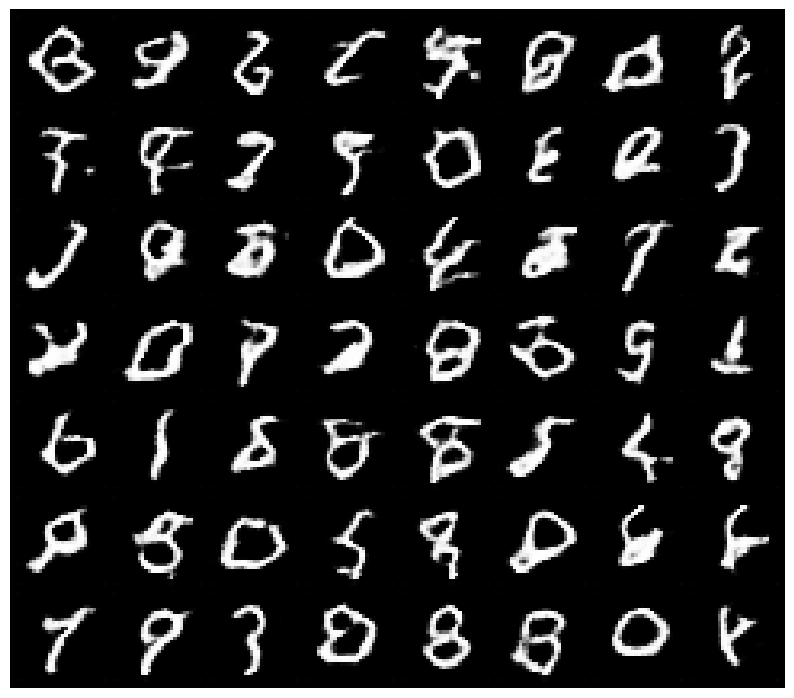

100%|████████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.84it/s, loss_D=1.2, loss_G=1.5]


Epoch [5/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [5/200] - Average D loss: 1.1943, Average G loss: 0.9282


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.00it/s, loss_D=1.25, loss_G=0.796]


Epoch [6/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [6/200] - Average D loss: 1.1412, Average G loss: 1.0035


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.67it/s, loss_D=1.13, loss_G=0.755]


Epoch [7/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [7/200] - Average D loss: 1.0954, Average G loss: 1.0856


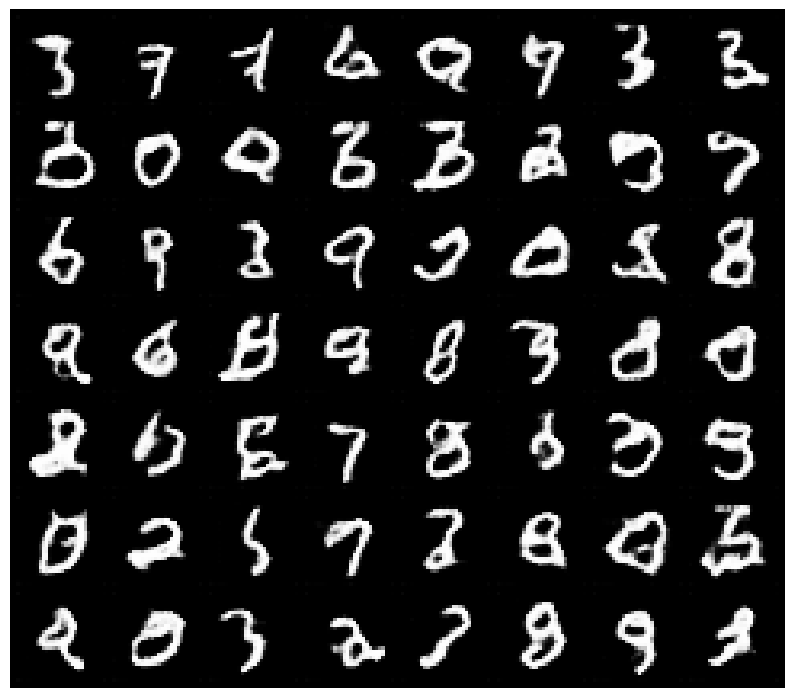

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.71it/s, loss_D=0.967, loss_G=1.16]


Epoch [8/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [8/200] - Average D loss: 1.0617, Average G loss: 1.1483


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.86it/s, loss_D=0.908, loss_G=1.44]


Epoch [9/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [9/200] - Average D loss: 1.0305, Average G loss: 1.2059


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.986, loss_G=1.3]


Epoch [10/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [10/200] - Average D loss: 1.0064, Average G loss: 1.2575


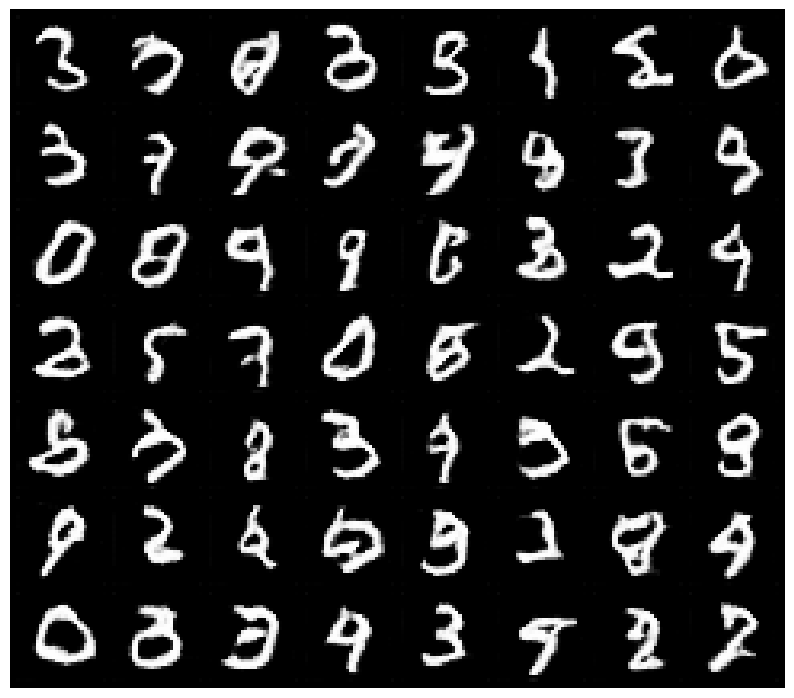

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.19it/s, loss_D=0.989, loss_G=1.01]


Epoch [11/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [11/200] - Average D loss: 0.9903, Average G loss: 1.2920


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.04it/s, loss_D=0.914, loss_G=1.61]


Epoch [12/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [12/200] - Average D loss: 0.9694, Average G loss: 1.3343


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.38it/s, loss_D=0.941, loss_G=1.54]


Epoch [13/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [13/200] - Average D loss: 0.9468, Average G loss: 1.3884


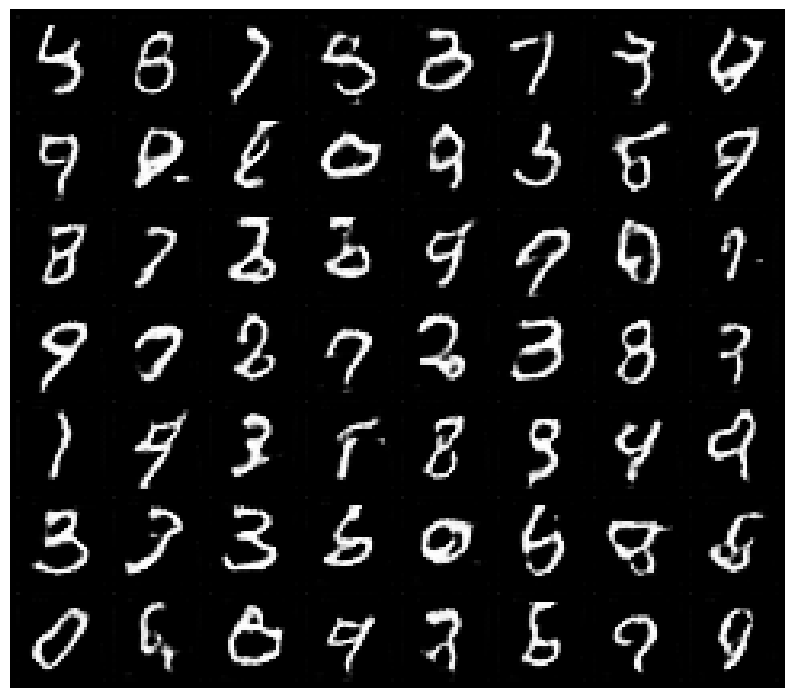

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.28it/s, loss_D=0.93, loss_G=1.14]


Epoch [14/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [14/200] - Average D loss: 0.9327, Average G loss: 1.4125


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.69it/s, loss_D=0.86, loss_G=1.32]


Epoch [15/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [15/200] - Average D loss: 0.9191, Average G loss: 1.4396


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.61it/s, loss_D=0.985, loss_G=1.32]


Epoch [16/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [16/200] - Average D loss: 0.9060, Average G loss: 1.4735


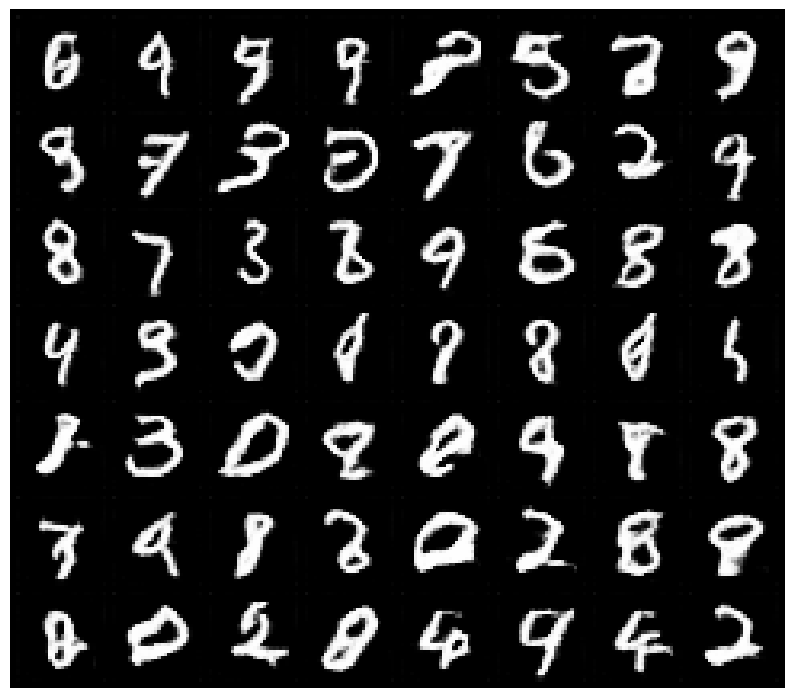

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.762, loss_G=1.46]


Epoch [17/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [17/200] - Average D loss: 0.8947, Average G loss: 1.5018


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.704, loss_G=1.54]


Epoch [18/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [18/200] - Average D loss: 0.8751, Average G loss: 1.5337


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.79, loss_G=1.65]


Epoch [19/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [19/200] - Average D loss: 0.8707, Average G loss: 1.5535


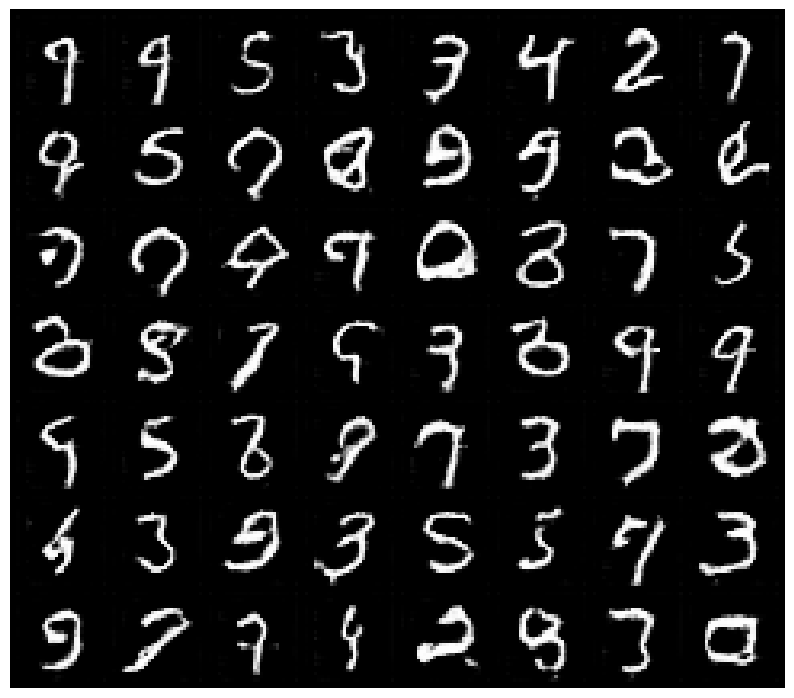

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.52it/s, loss_D=0.743, loss_G=1.63]


Epoch [20/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [20/200] - Average D loss: 0.8592, Average G loss: 1.5835


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.28it/s, loss_D=0.674, loss_G=1.92]


Epoch [21/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [21/200] - Average D loss: 0.8338, Average G loss: 1.6099


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.48it/s, loss_D=0.927, loss_G=1.45]


Epoch [22/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [22/200] - Average D loss: 0.8268, Average G loss: 1.6318


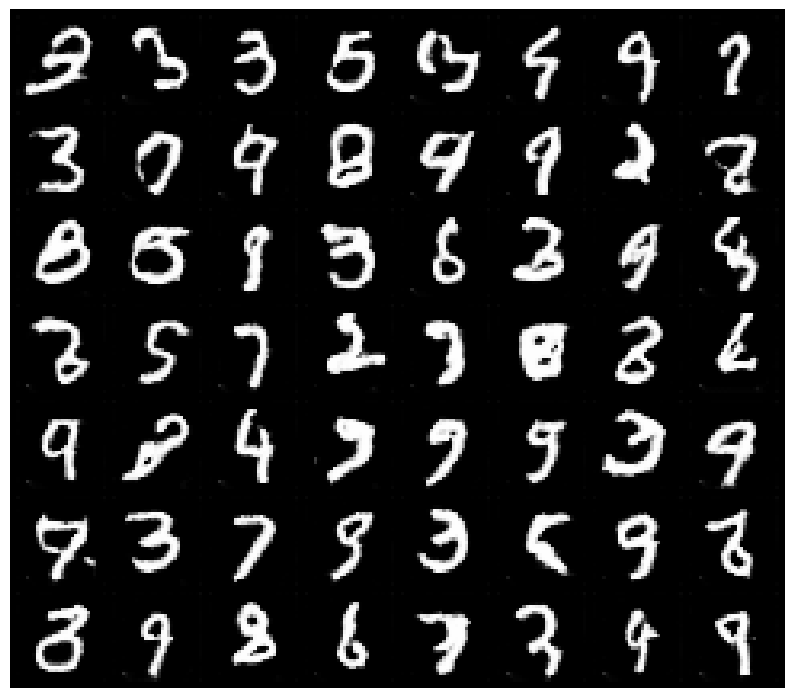

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.60it/s, loss_D=0.782, loss_G=1.55]


Epoch [23/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [23/200] - Average D loss: 0.8237, Average G loss: 1.6501


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.57it/s, loss_D=0.891, loss_G=1.91]


Epoch [24/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [24/200] - Average D loss: 0.8182, Average G loss: 1.6682


100%|███████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.05it/s, loss_D=0.9, loss_G=1.81]


Epoch [25/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [25/200] - Average D loss: 0.8129, Average G loss: 1.6835


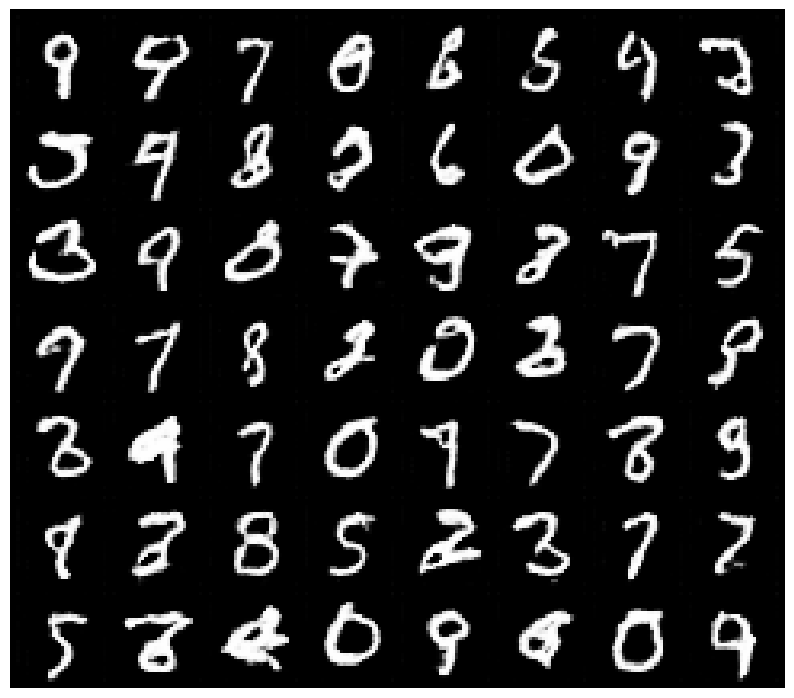

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.51it/s, loss_D=0.775, loss_G=1.63]


Epoch [26/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [26/200] - Average D loss: 0.8044, Average G loss: 1.6927


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 31.98it/s, loss_D=0.93, loss_G=1.45]


Epoch [27/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [27/200] - Average D loss: 0.8108, Average G loss: 1.6947


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.38it/s, loss_D=0.941, loss_G=1.4]


Epoch [28/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [28/200] - Average D loss: 0.8004, Average G loss: 1.7106


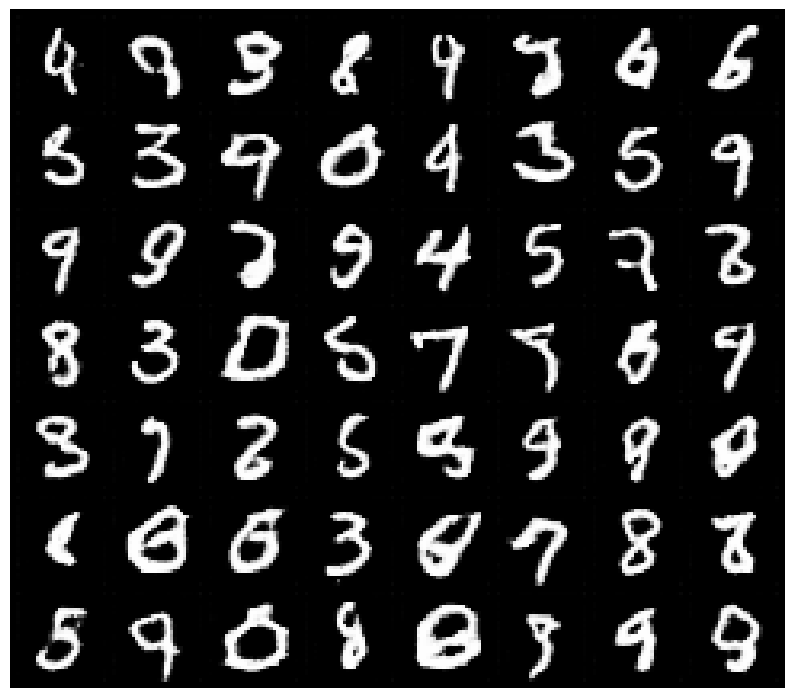

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.46it/s, loss_D=0.755, loss_G=1.62]


Epoch [29/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [29/200] - Average D loss: 0.7939, Average G loss: 1.7171


100%|███████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.55it/s, loss_D=0.85, loss_G=1.4]


Epoch [30/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [30/200] - Average D loss: 0.7899, Average G loss: 1.7331


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.49it/s, loss_D=0.723, loss_G=1.95]


Epoch [31/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [31/200] - Average D loss: 0.7885, Average G loss: 1.7386


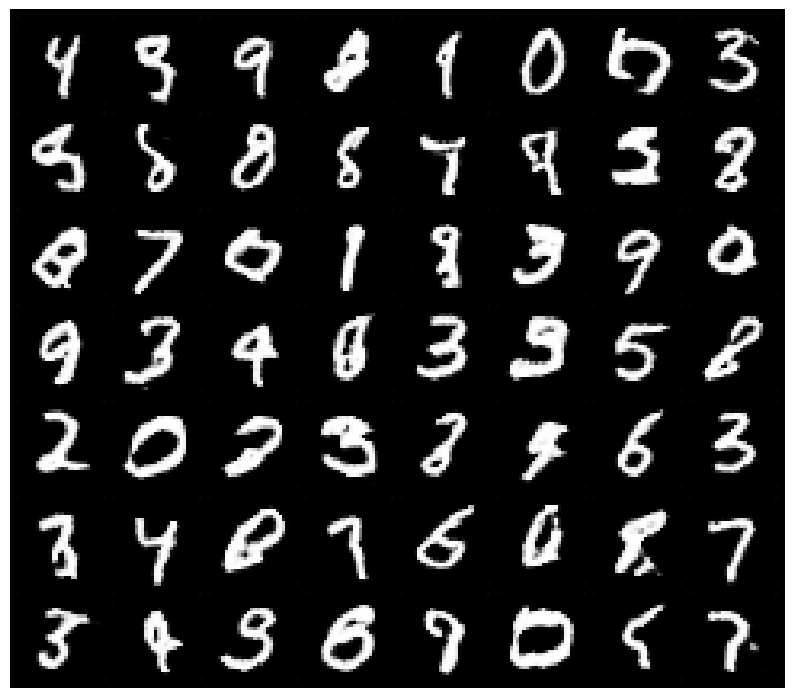

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.59it/s, loss_D=0.778, loss_G=1.54]


Epoch [32/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [32/200] - Average D loss: 0.7834, Average G loss: 1.7383


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.46it/s, loss_D=0.899, loss_G=1.71]


Epoch [33/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [33/200] - Average D loss: 0.7894, Average G loss: 1.7399


100%|███████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.41it/s, loss_D=0.9, loss_G=1.71]


Epoch [34/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [34/200] - Average D loss: 0.7744, Average G loss: 1.7553


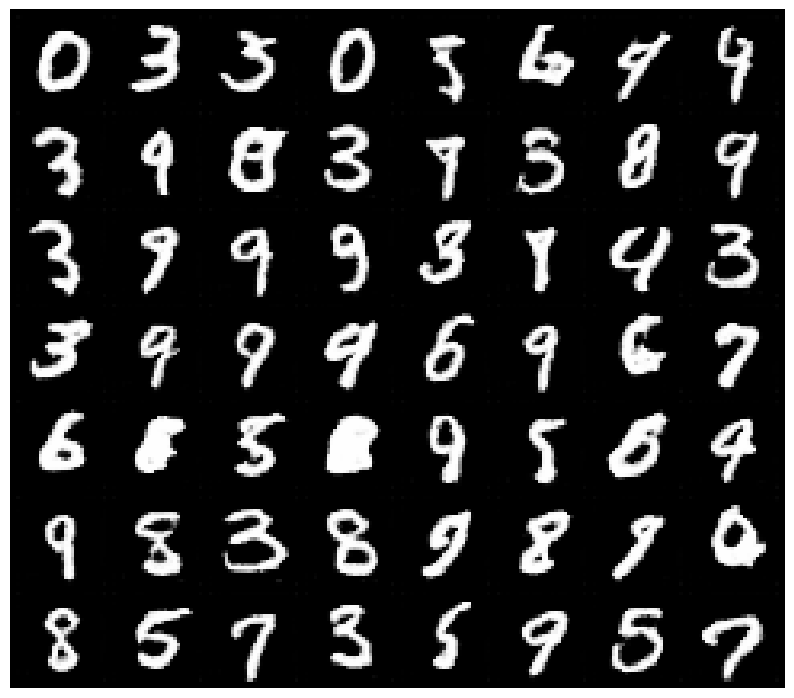

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.19it/s, loss_D=0.793, loss_G=1.73]


Epoch [35/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [35/200] - Average D loss: 0.7740, Average G loss: 1.7579


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.16it/s, loss_D=0.788, loss_G=1.33]


Epoch [36/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [36/200] - Average D loss: 0.7777, Average G loss: 1.7563


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.96it/s, loss_D=0.732, loss_G=1.63]


Epoch [37/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [37/200] - Average D loss: 0.7709, Average G loss: 1.7620


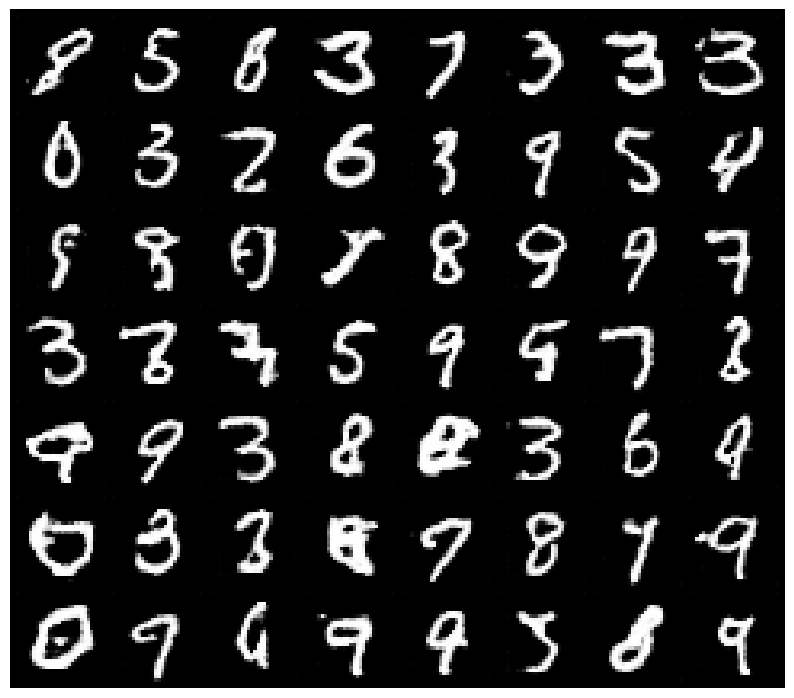

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.95it/s, loss_D=0.713, loss_G=1.56]


Epoch [38/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [38/200] - Average D loss: 0.7687, Average G loss: 1.7701


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.98it/s, loss_D=0.921, loss_G=1.74]


Epoch [39/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [39/200] - Average D loss: 0.7686, Average G loss: 1.7697


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.02it/s, loss_D=0.818, loss_G=1.43]


Epoch [40/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [40/200] - Average D loss: 0.7743, Average G loss: 1.7486


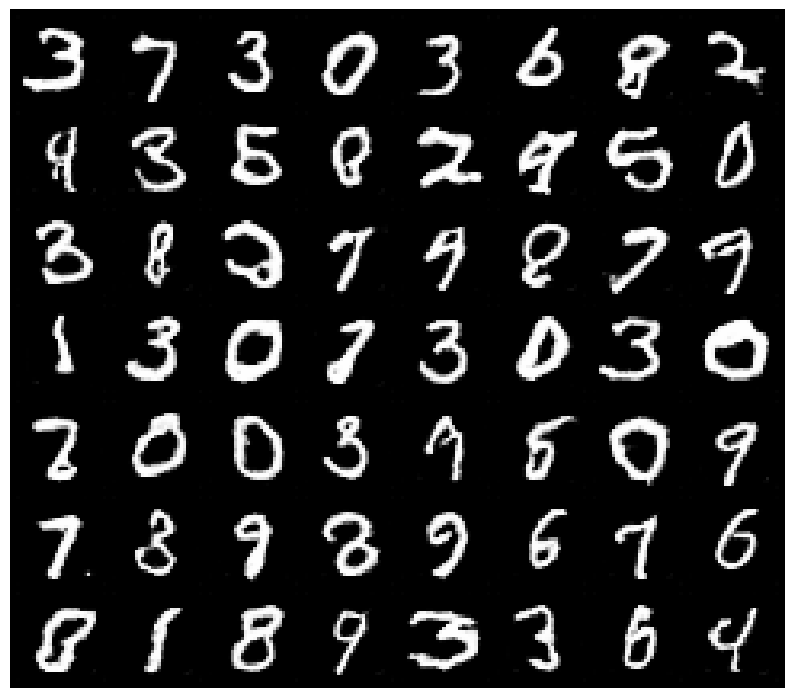

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.05it/s, loss_D=0.712, loss_G=1.87]


Epoch [41/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [41/200] - Average D loss: 0.7550, Average G loss: 1.7605


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.72it/s, loss_D=0.688, loss_G=1.84]


Epoch [42/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [42/200] - Average D loss: 0.7582, Average G loss: 1.7584


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.76it/s, loss_D=0.63, loss_G=1.62]


Epoch [43/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [43/200] - Average D loss: 0.7585, Average G loss: 1.7578


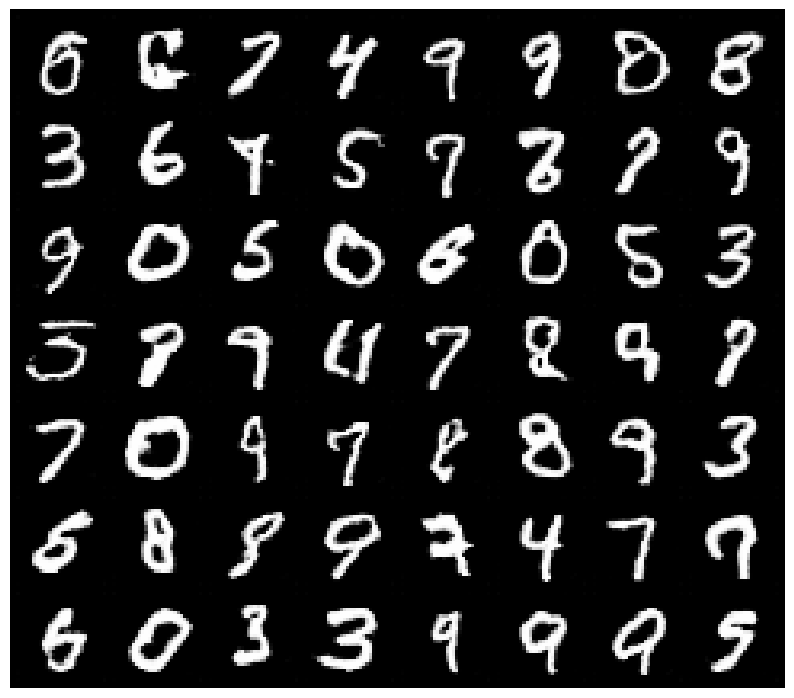

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.90it/s, loss_D=0.76, loss_G=1.93]


Epoch [44/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [44/200] - Average D loss: 0.7561, Average G loss: 1.7597


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.74it/s, loss_D=0.558, loss_G=2.06]


Epoch [45/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [45/200] - Average D loss: 0.7579, Average G loss: 1.7610


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.81it/s, loss_D=0.676, loss_G=1.93]


Epoch [46/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [46/200] - Average D loss: 0.7575, Average G loss: 1.7562


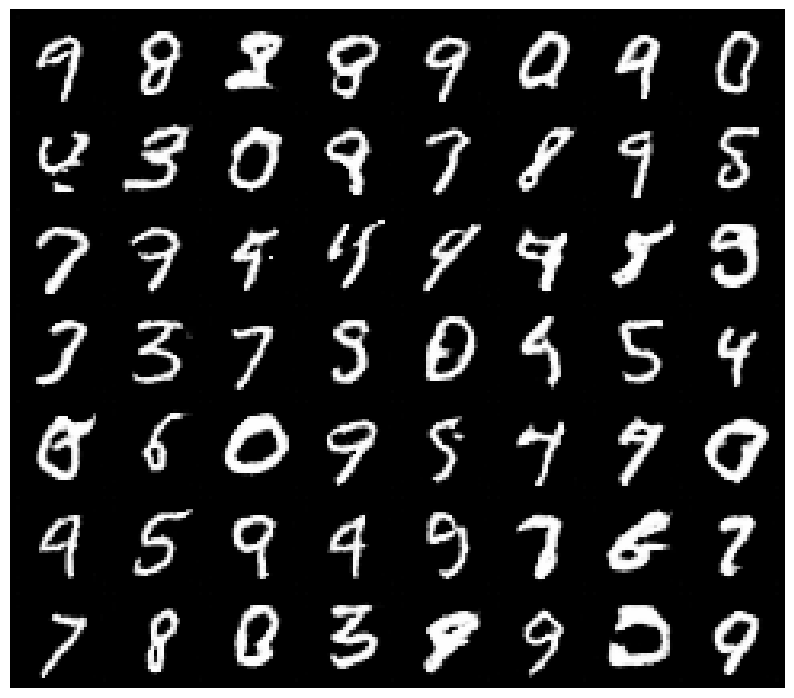

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.88it/s, loss_D=0.693, loss_G=1.88]


Epoch [47/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [47/200] - Average D loss: 0.7611, Average G loss: 1.7361


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.86it/s, loss_D=0.697, loss_G=1.93]


Epoch [48/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [48/200] - Average D loss: 0.7568, Average G loss: 1.7558


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.89it/s, loss_D=0.722, loss_G=1.33]


Epoch [49/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [49/200] - Average D loss: 0.7558, Average G loss: 1.7661


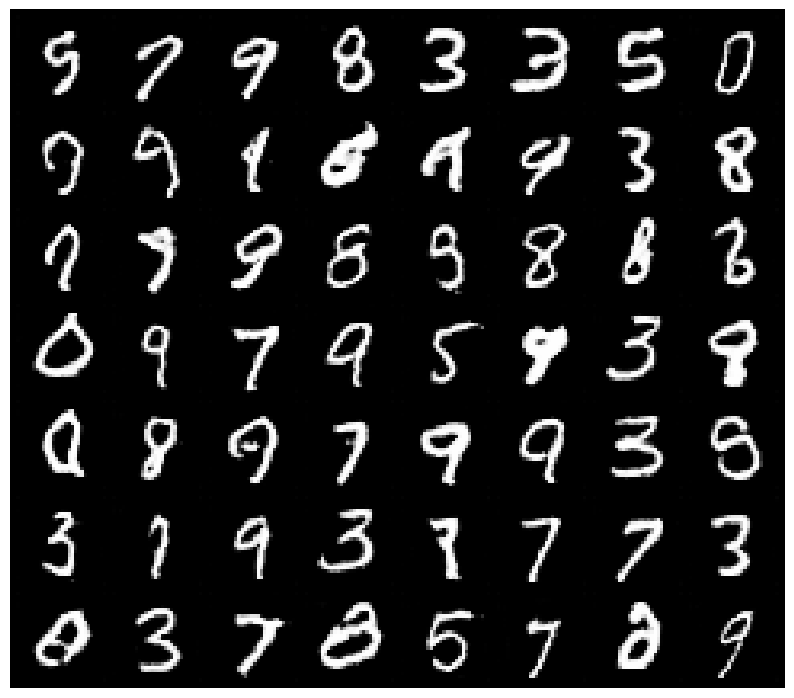

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.93it/s, loss_D=0.738, loss_G=1.79]


Epoch [50/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/200] - Average D loss: 0.7562, Average G loss: 1.7561


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.01it/s, loss_D=0.691, loss_G=2.06]


Epoch [51/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/200] - Average D loss: 0.7545, Average G loss: 1.7520


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.03it/s, loss_D=0.736, loss_G=1.31]


Epoch [52/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/200] - Average D loss: 0.7557, Average G loss: 1.7504


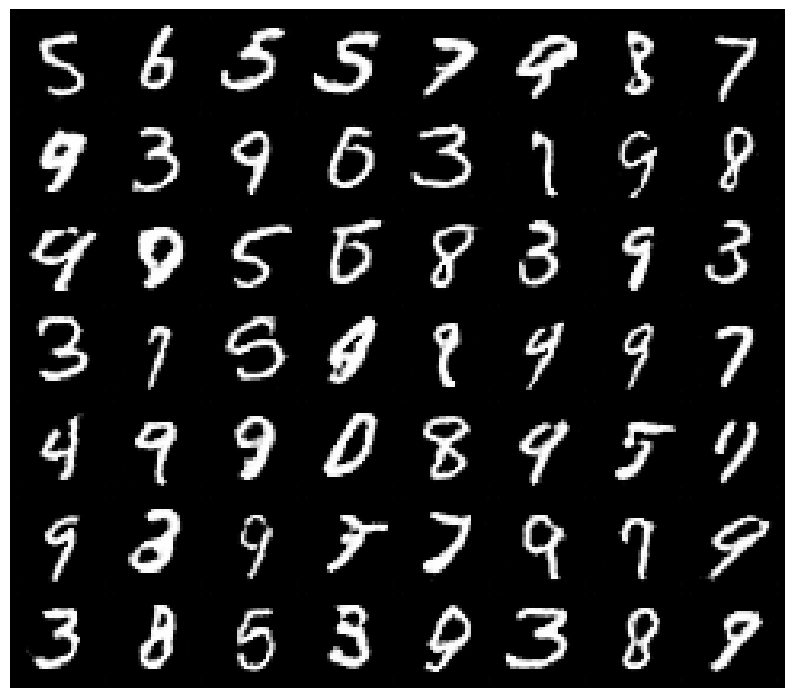

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.88it/s, loss_D=0.783, loss_G=1.53]


Epoch [53/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/200] - Average D loss: 0.7525, Average G loss: 1.7532


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.86it/s, loss_D=0.837, loss_G=1.75]


Epoch [54/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/200] - Average D loss: 0.7604, Average G loss: 1.7523


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.91it/s, loss_D=0.822, loss_G=1.9]


Epoch [55/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/200] - Average D loss: 0.7598, Average G loss: 1.7305


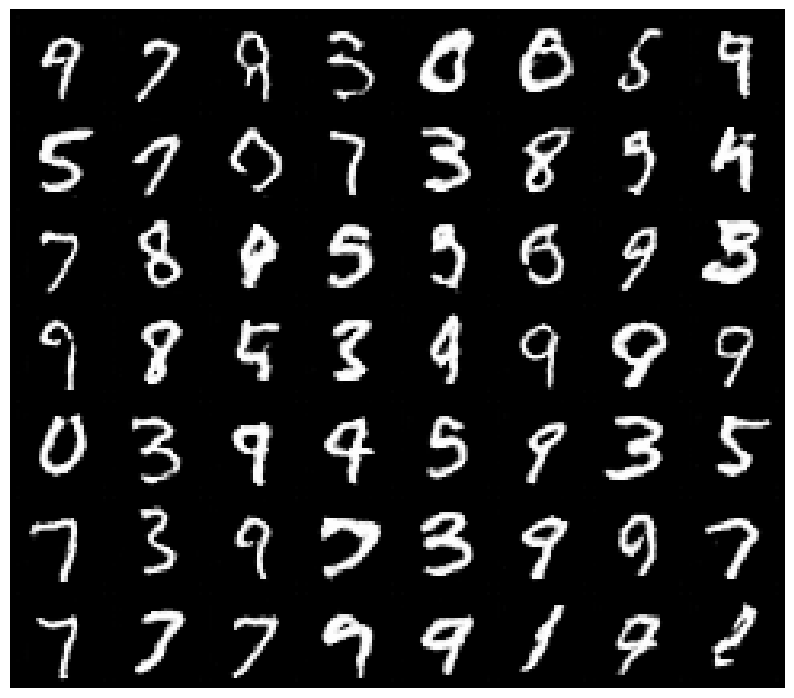

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.85it/s, loss_D=0.723, loss_G=1.9]


Epoch [56/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/200] - Average D loss: 0.7602, Average G loss: 1.7407


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 33.00it/s, loss_D=0.721, loss_G=1.72]


Epoch [57/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/200] - Average D loss: 0.7611, Average G loss: 1.7324


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.81it/s, loss_D=0.747, loss_G=2.27]


Epoch [58/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/200] - Average D loss: 0.7661, Average G loss: 1.7363


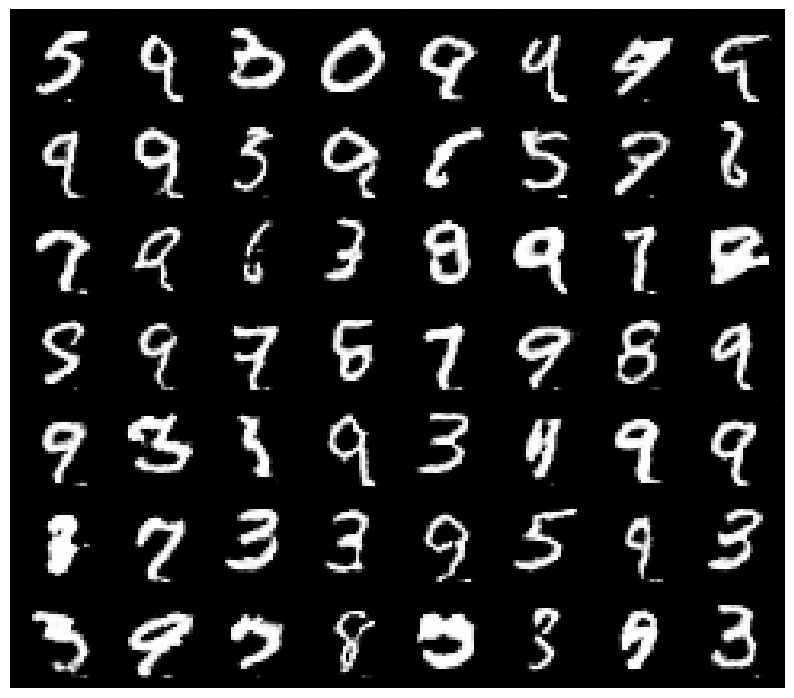

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.90it/s, loss_D=1.17, loss_G=2.42]


Epoch [59/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/200] - Average D loss: 0.7610, Average G loss: 1.7351


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.88it/s, loss_D=0.69, loss_G=1.85]


Epoch [60/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/200] - Average D loss: 0.7663, Average G loss: 1.7180


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.814, loss_G=1.67]


Epoch [61/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/200] - Average D loss: 0.7655, Average G loss: 1.6972


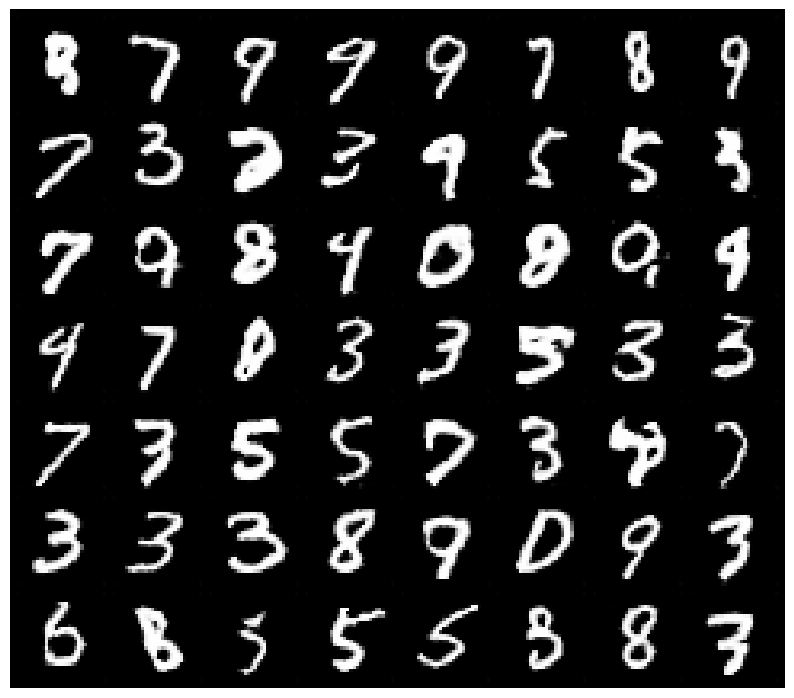

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.77it/s, loss_D=0.756, loss_G=1.6]


Epoch [62/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/200] - Average D loss: 0.7657, Average G loss: 1.7010


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.85it/s, loss_D=0.781, loss_G=1.55]


Epoch [63/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/200] - Average D loss: 0.7696, Average G loss: 1.6953


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.89it/s, loss_D=0.85, loss_G=2.26]


Epoch [64/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/200] - Average D loss: 0.7713, Average G loss: 1.6964


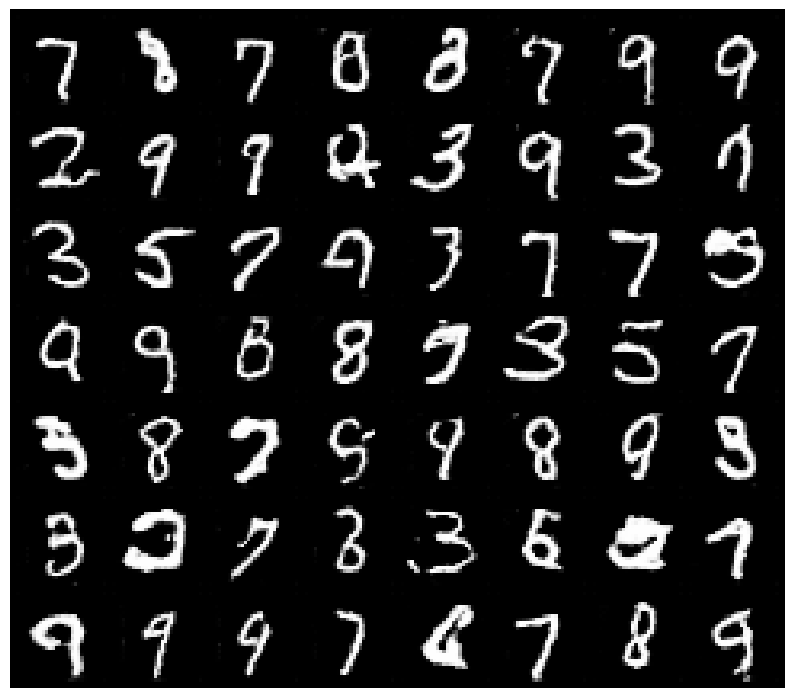

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.86it/s, loss_D=0.583, loss_G=1.78]


Epoch [65/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/200] - Average D loss: 0.7657, Average G loss: 1.7028


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.94it/s, loss_D=0.699, loss_G=1.92]


Epoch [66/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/200] - Average D loss: 0.7649, Average G loss: 1.7004


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.85it/s, loss_D=0.545, loss_G=1.82]


Epoch [67/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/200] - Average D loss: 0.7715, Average G loss: 1.6921


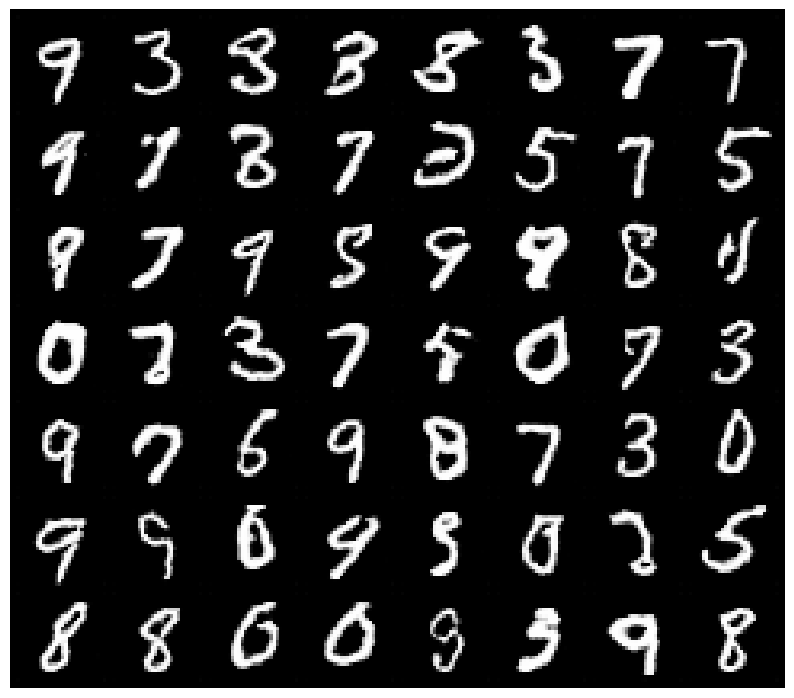

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.86it/s, loss_D=0.708, loss_G=1.83]


Epoch [68/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/200] - Average D loss: 0.7707, Average G loss: 1.6914


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.87it/s, loss_D=0.734, loss_G=1.85]


Epoch [69/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/200] - Average D loss: 0.7706, Average G loss: 1.6832


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.84it/s, loss_D=0.721, loss_G=2.05]


Epoch [70/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [70/200] - Average D loss: 0.7672, Average G loss: 1.7056


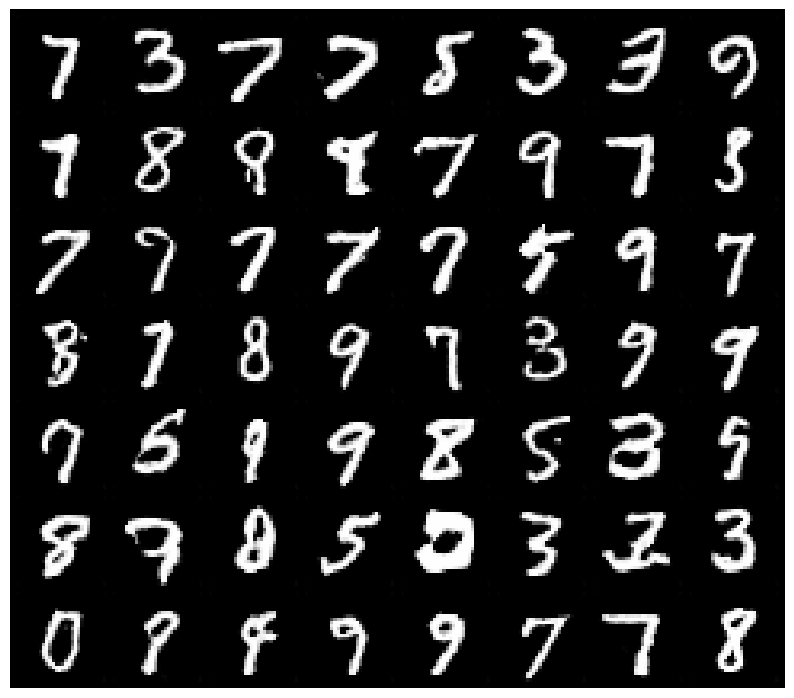

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.82it/s, loss_D=0.828, loss_G=1.51]


Epoch [71/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [71/200] - Average D loss: 0.7745, Average G loss: 1.6771


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.78it/s, loss_D=0.73, loss_G=2.15]


Epoch [72/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [72/200] - Average D loss: 0.7655, Average G loss: 1.6942


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.61it/s, loss_D=0.88, loss_G=1.72]


Epoch [73/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [73/200] - Average D loss: 0.7686, Average G loss: 1.6928


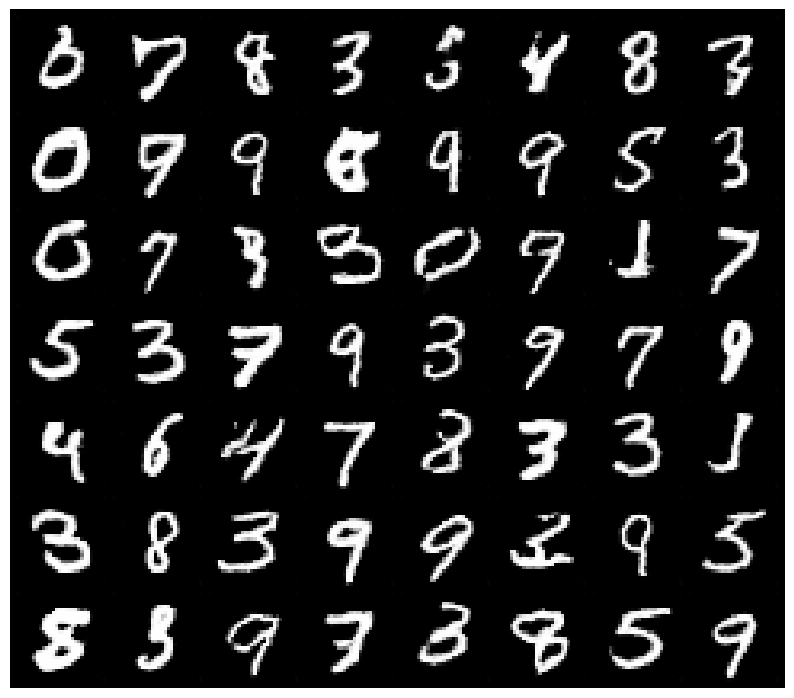

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.65it/s, loss_D=0.645, loss_G=1.77]


Epoch [74/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [74/200] - Average D loss: 0.7720, Average G loss: 1.6834


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.82it/s, loss_D=0.681, loss_G=1.86]


Epoch [75/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [75/200] - Average D loss: 0.7725, Average G loss: 1.6863


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.75it/s, loss_D=0.73, loss_G=1.88]


Epoch [76/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [76/200] - Average D loss: 0.7710, Average G loss: 1.6872


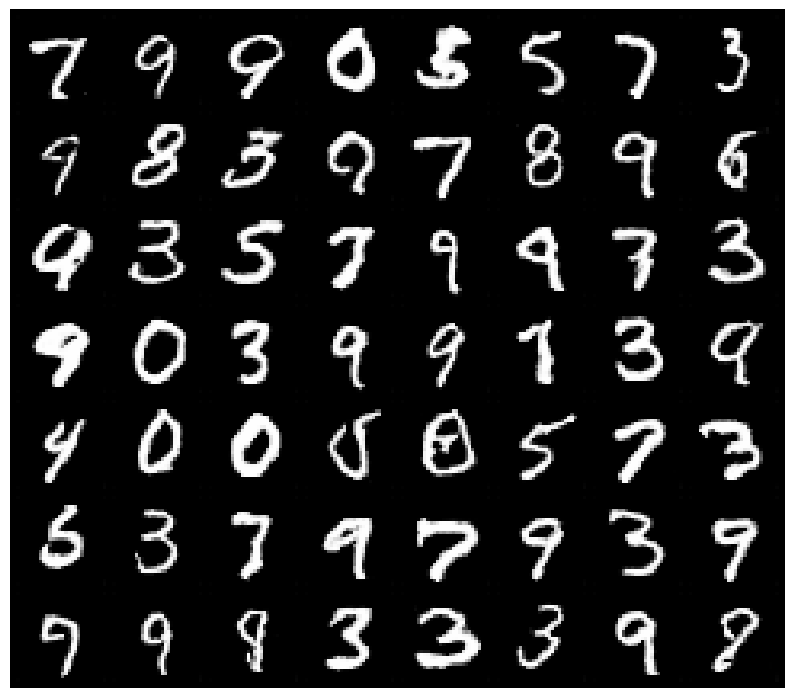

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.94it/s, loss_D=0.744, loss_G=1.58]


Epoch [77/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [77/200] - Average D loss: 0.7705, Average G loss: 1.6807


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.77it/s, loss_D=0.751, loss_G=1.55]


Epoch [78/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [78/200] - Average D loss: 0.7741, Average G loss: 1.6780


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.92it/s, loss_D=0.721, loss_G=1.79]


Epoch [79/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [79/200] - Average D loss: 0.7724, Average G loss: 1.6769


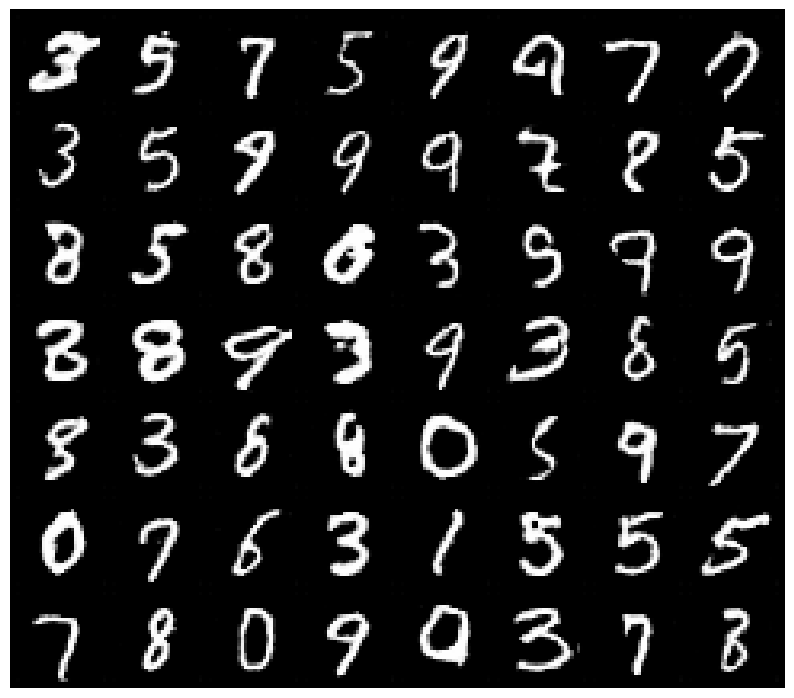

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.87it/s, loss_D=0.876, loss_G=1.75]


Epoch [80/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [80/200] - Average D loss: 0.7707, Average G loss: 1.6819


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.78it/s, loss_D=0.557, loss_G=1.99]


Epoch [81/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [81/200] - Average D loss: 0.7692, Average G loss: 1.6717


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.81it/s, loss_D=0.699, loss_G=1.79]


Epoch [82/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [82/200] - Average D loss: 0.7680, Average G loss: 1.6805


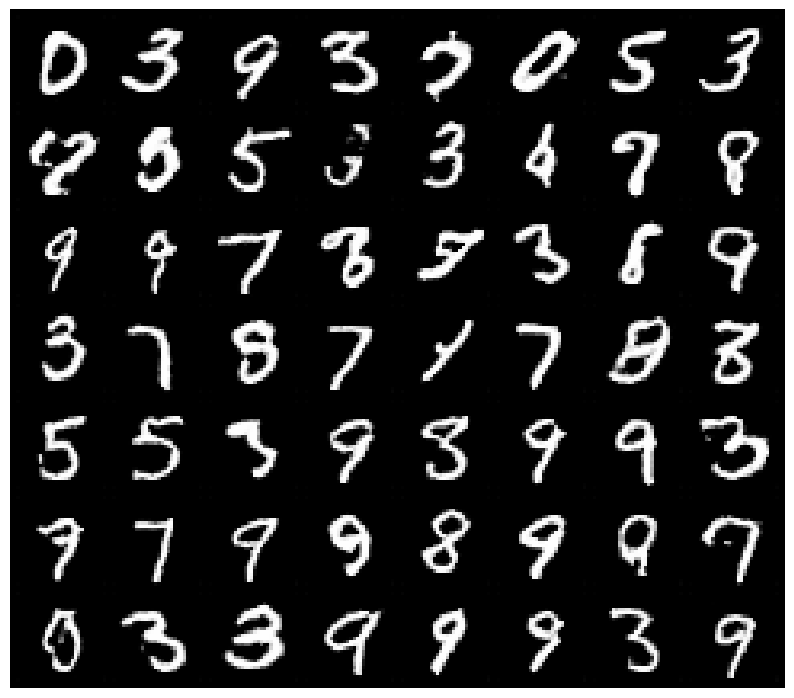

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.82it/s, loss_D=0.92, loss_G=1.66]


Epoch [83/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [83/200] - Average D loss: 0.7684, Average G loss: 1.6756


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.81it/s, loss_D=0.785, loss_G=1.74]


Epoch [84/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [84/200] - Average D loss: 0.7711, Average G loss: 1.6709


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.79it/s, loss_D=0.834, loss_G=1.8]


Epoch [85/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [85/200] - Average D loss: 0.7733, Average G loss: 1.6799


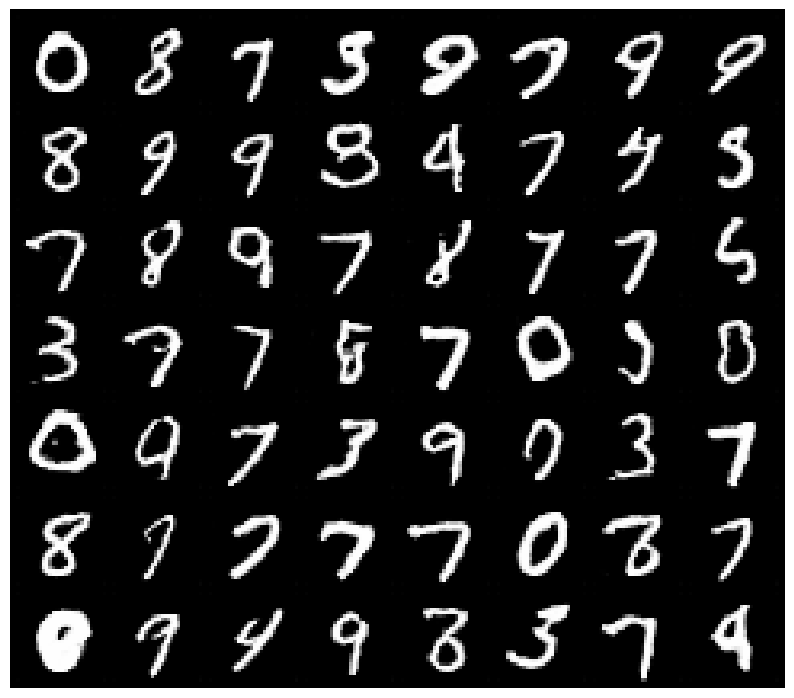

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.88it/s, loss_D=0.775, loss_G=1.59]


Epoch [86/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [86/200] - Average D loss: 0.7743, Average G loss: 1.6704


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.80it/s, loss_D=0.62, loss_G=1.61]


Epoch [87/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [87/200] - Average D loss: 0.7681, Average G loss: 1.6729


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.80it/s, loss_D=0.601, loss_G=1.59]


Epoch [88/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [88/200] - Average D loss: 0.7678, Average G loss: 1.6837


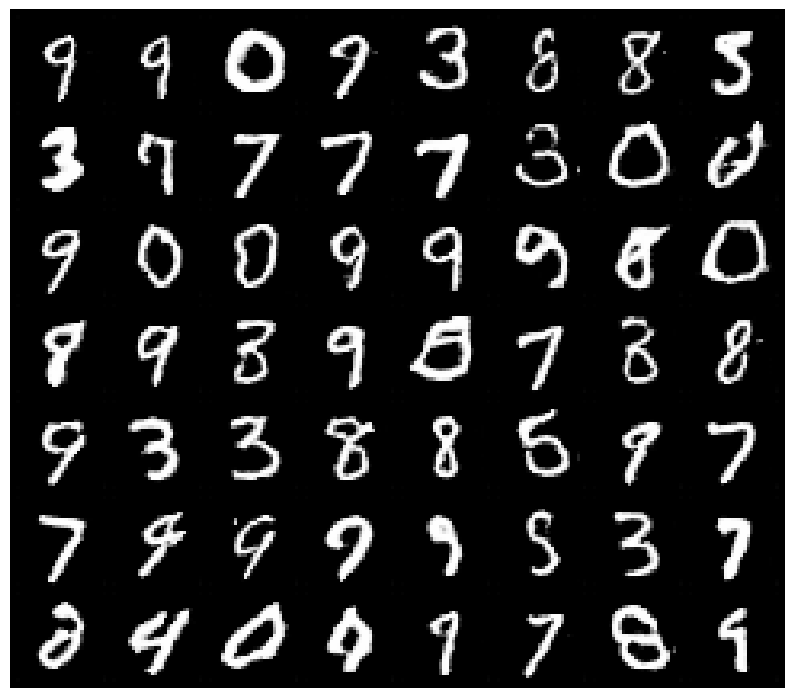

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.81it/s, loss_D=0.881, loss_G=1.91]


Epoch [89/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [89/200] - Average D loss: 0.7719, Average G loss: 1.6726


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.65it/s, loss_D=0.666, loss_G=1.79]


Epoch [90/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [90/200] - Average D loss: 0.7717, Average G loss: 1.6712


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.75it/s, loss_D=0.902, loss_G=1.27]


Epoch [91/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [91/200] - Average D loss: 0.7718, Average G loss: 1.6701


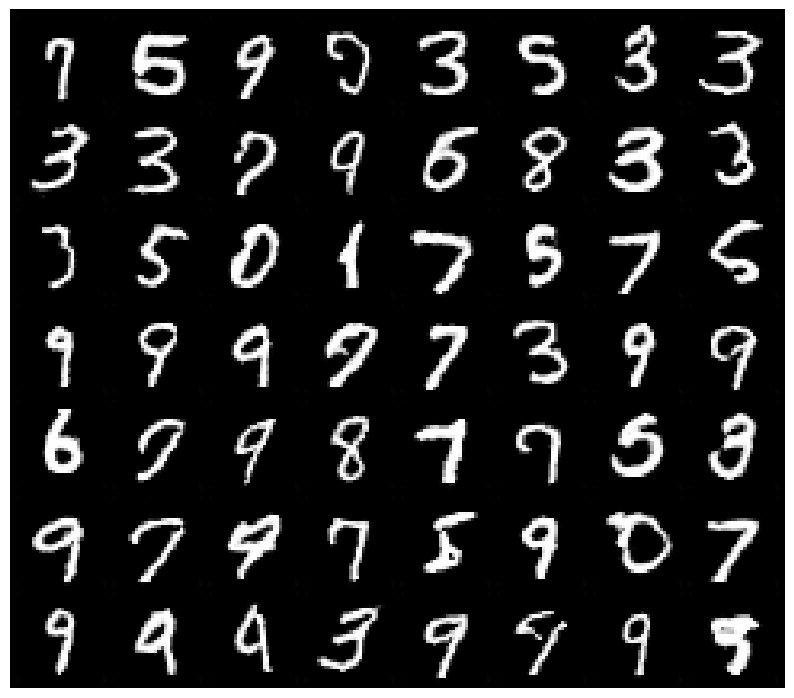

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.70it/s, loss_D=0.803, loss_G=1.62]


Epoch [92/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [92/200] - Average D loss: 0.7660, Average G loss: 1.6773


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.73it/s, loss_D=0.71, loss_G=1.33]


Epoch [93/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [93/200] - Average D loss: 0.7678, Average G loss: 1.6804


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.80it/s, loss_D=0.787, loss_G=1.74]


Epoch [94/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [94/200] - Average D loss: 0.7700, Average G loss: 1.6853


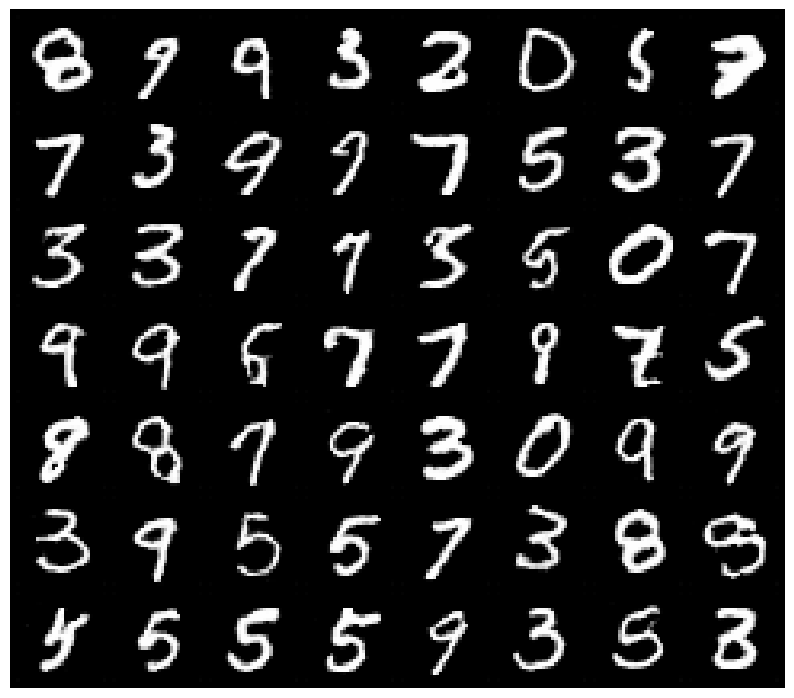

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.72it/s, loss_D=0.688, loss_G=1.85]


Epoch [95/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [95/200] - Average D loss: 0.7696, Average G loss: 1.6783


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.58it/s, loss_D=0.703, loss_G=1.83]


Epoch [96/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [96/200] - Average D loss: 0.7636, Average G loss: 1.6867


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.79it/s, loss_D=0.638, loss_G=1.73]


Epoch [97/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [97/200] - Average D loss: 0.7684, Average G loss: 1.6858


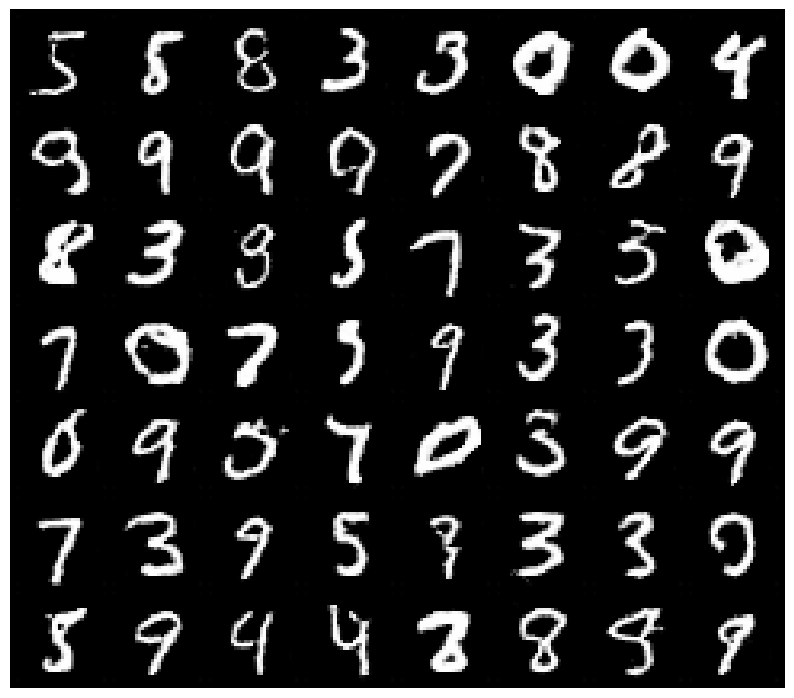

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.70it/s, loss_D=0.698, loss_G=1.57]


Epoch [98/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [98/200] - Average D loss: 0.7716, Average G loss: 1.6745


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.81, loss_G=1.63]


Epoch [99/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [99/200] - Average D loss: 0.7672, Average G loss: 1.6843


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.82it/s, loss_D=0.739, loss_G=1.63]


Epoch [100/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [100/200] - Average D loss: 0.7647, Average G loss: 1.6892


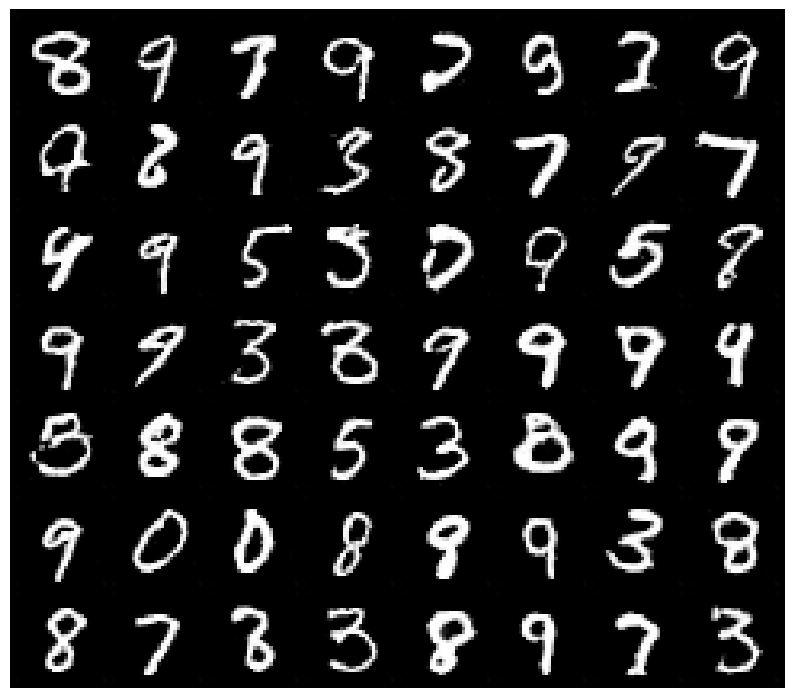

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.56it/s, loss_D=0.795, loss_G=1.66]


Epoch [101/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [101/200] - Average D loss: 0.7655, Average G loss: 1.6709


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.78it/s, loss_D=0.788, loss_G=1.8]


Epoch [102/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [102/200] - Average D loss: 0.7681, Average G loss: 1.6814


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.67it/s, loss_D=0.972, loss_G=1.66]


Epoch [103/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [103/200] - Average D loss: 0.7655, Average G loss: 1.6799


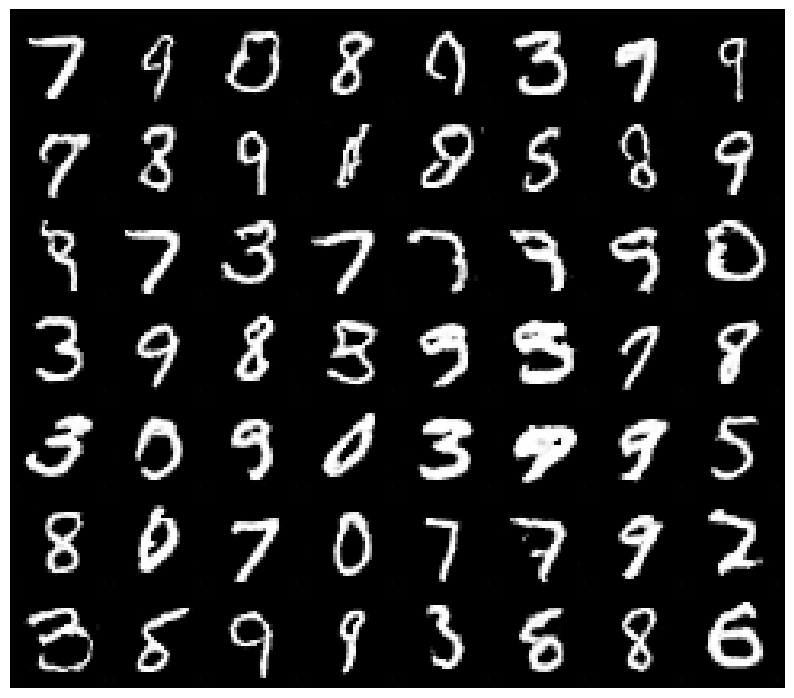

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.16it/s, loss_D=0.59, loss_G=1.78]


Epoch [104/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [104/200] - Average D loss: 0.7681, Average G loss: 1.6712


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 31.90it/s, loss_D=0.634, loss_G=1.47]


Epoch [105/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [105/200] - Average D loss: 0.7661, Average G loss: 1.6779


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.36it/s, loss_D=0.936, loss_G=1.51]


Epoch [106/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [106/200] - Average D loss: 0.7707, Average G loss: 1.6747


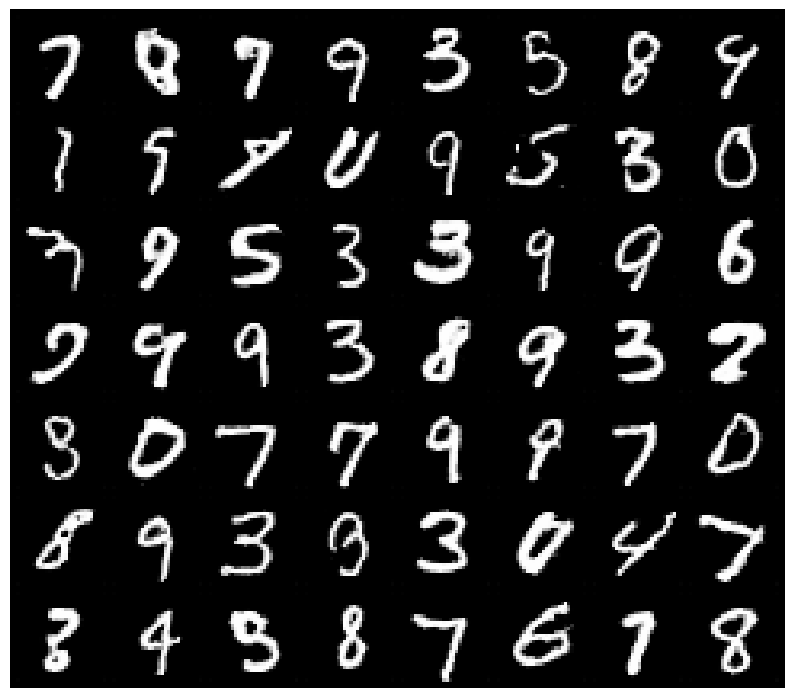

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.27it/s, loss_D=0.797, loss_G=1.69]


Epoch [107/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [107/200] - Average D loss: 0.7674, Average G loss: 1.6766


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.61it/s, loss_D=0.667, loss_G=1.81]


Epoch [108/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [108/200] - Average D loss: 0.7633, Average G loss: 1.6834


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.49it/s, loss_D=0.88, loss_G=1.42]


Epoch [109/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [109/200] - Average D loss: 0.7672, Average G loss: 1.6792


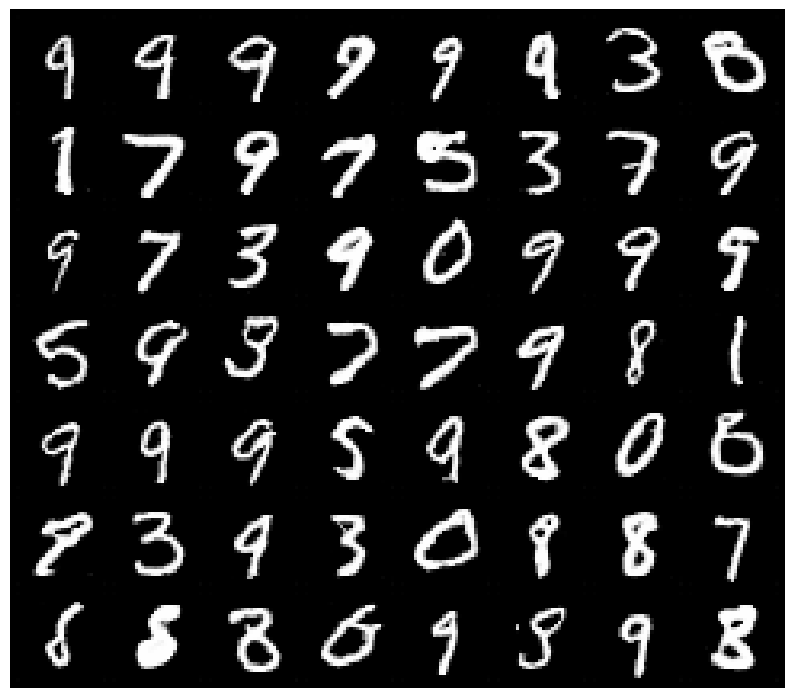

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.782, loss_G=1.64]


Epoch [110/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [110/200] - Average D loss: 0.7648, Average G loss: 1.6805


100%|███████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.59it/s, loss_D=0.9, loss_G=1.61]


Epoch [111/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [111/200] - Average D loss: 0.7617, Average G loss: 1.6841


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.67it/s, loss_D=0.835, loss_G=1.45]


Epoch [112/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [112/200] - Average D loss: 0.7644, Average G loss: 1.6854


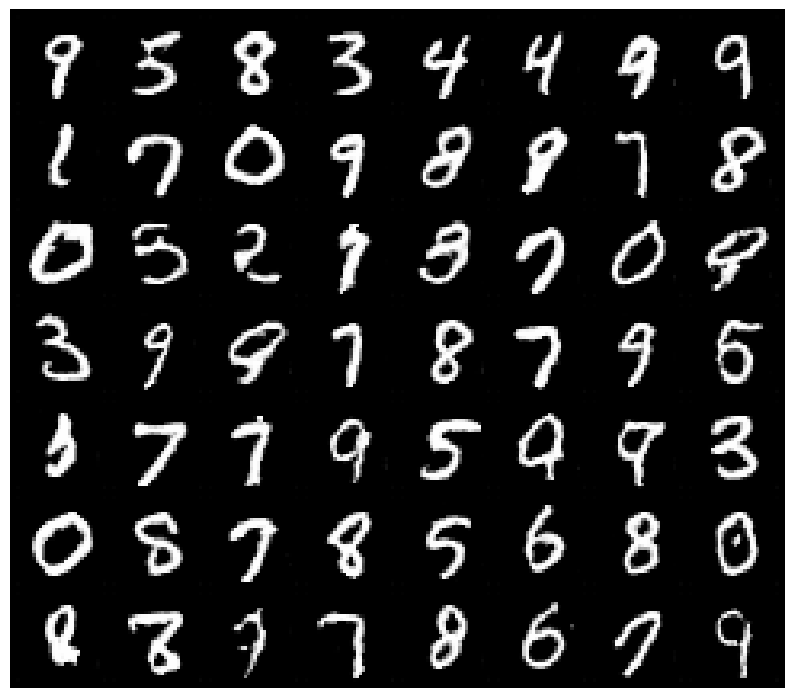

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.677, loss_G=1.6]


Epoch [113/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [113/200] - Average D loss: 0.7636, Average G loss: 1.6852


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.68it/s, loss_D=0.652, loss_G=1.66]


Epoch [114/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [114/200] - Average D loss: 0.7656, Average G loss: 1.6777


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.61it/s, loss_D=0.746, loss_G=1.61]


Epoch [115/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [115/200] - Average D loss: 0.7632, Average G loss: 1.6845


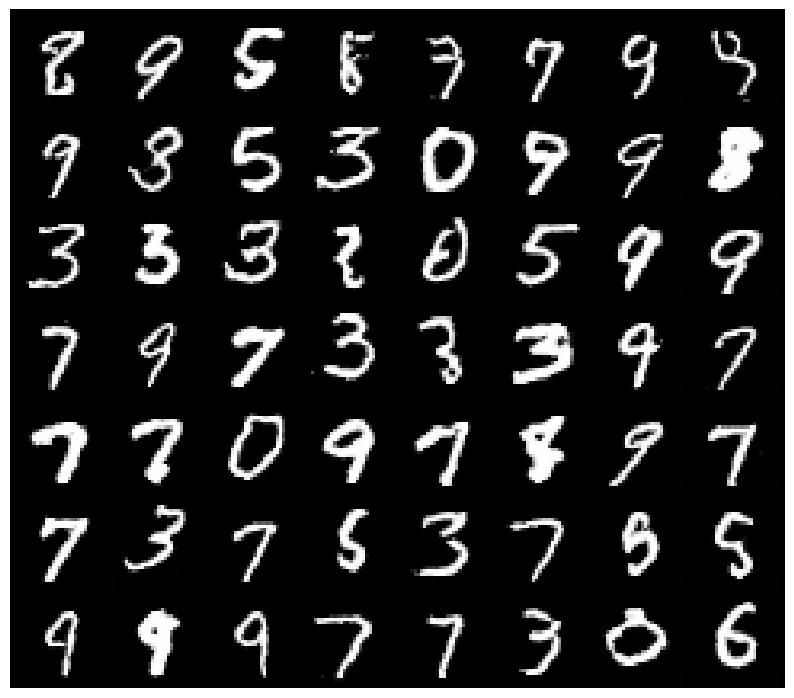

100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.38it/s, loss_D=0.73, loss_G=1.78]


Epoch [116/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [116/200] - Average D loss: 0.7624, Average G loss: 1.6901


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.36it/s, loss_D=0.71, loss_G=1.53]


Epoch [117/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [117/200] - Average D loss: 0.7661, Average G loss: 1.6875


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.903, loss_G=1.71]


Epoch [118/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [118/200] - Average D loss: 0.7692, Average G loss: 1.6842


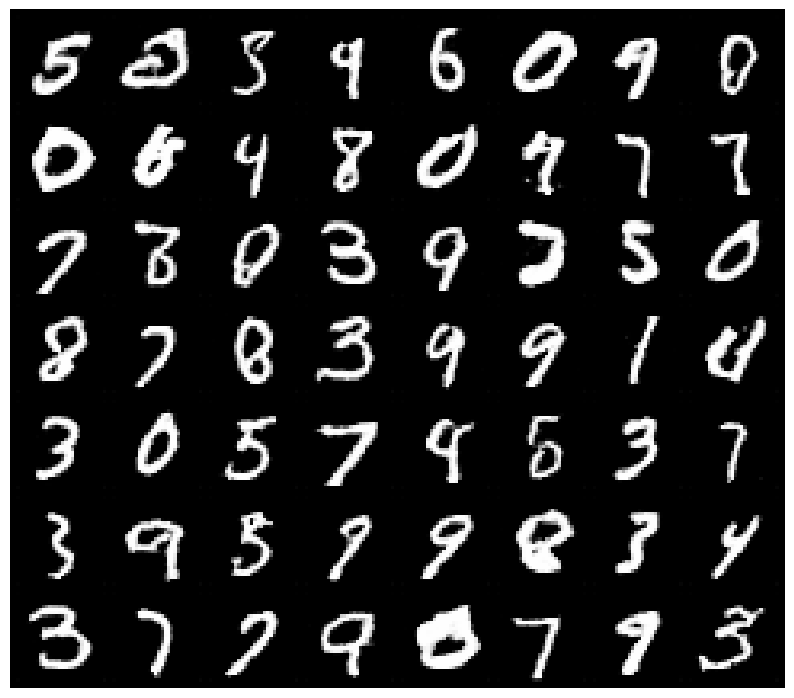

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.51it/s, loss_D=0.756, loss_G=1.93]


Epoch [119/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [119/200] - Average D loss: 0.7671, Average G loss: 1.6793


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.41it/s, loss_D=0.709, loss_G=1.4]


Epoch [120/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [120/200] - Average D loss: 0.7587, Average G loss: 1.6911


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.43it/s, loss_D=0.621, loss_G=1.78]


Epoch [121/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [121/200] - Average D loss: 0.7579, Average G loss: 1.6836


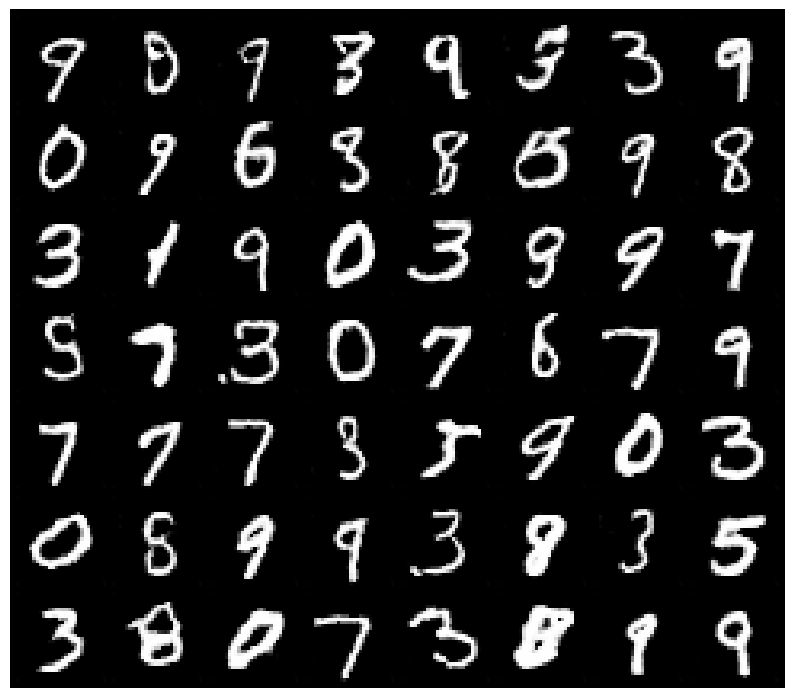

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.10it/s, loss_D=0.647, loss_G=1.64]


Epoch [122/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [122/200] - Average D loss: 0.7643, Average G loss: 1.6801


100%|█████████████████████████████████████████████████████| 732/732 [00:25<00:00, 29.05it/s, loss_D=0.845, loss_G=1.89]


Epoch [123/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [123/200] - Average D loss: 0.7626, Average G loss: 1.6900


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.62it/s, loss_D=0.939, loss_G=1.67]


Epoch [124/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [124/200] - Average D loss: 0.7637, Average G loss: 1.6845


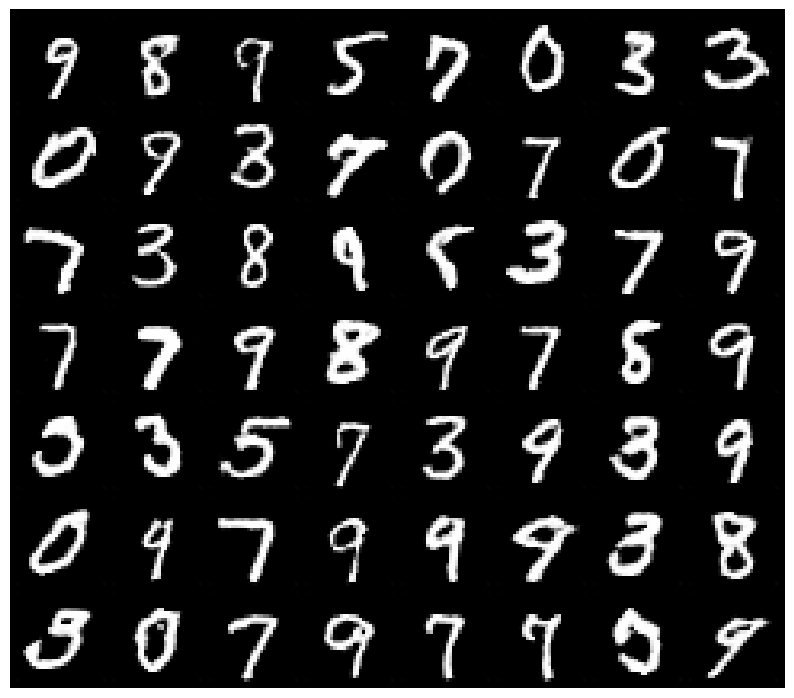

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.20it/s, loss_D=0.818, loss_G=1.72]


Epoch [125/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [125/200] - Average D loss: 0.7586, Average G loss: 1.6884


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.27it/s, loss_D=0.708, loss_G=1.7]


Epoch [126/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [126/200] - Average D loss: 0.7571, Average G loss: 1.7002


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.19it/s, loss_D=0.997, loss_G=1.5]


Epoch [127/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [127/200] - Average D loss: 0.7651, Average G loss: 1.6797


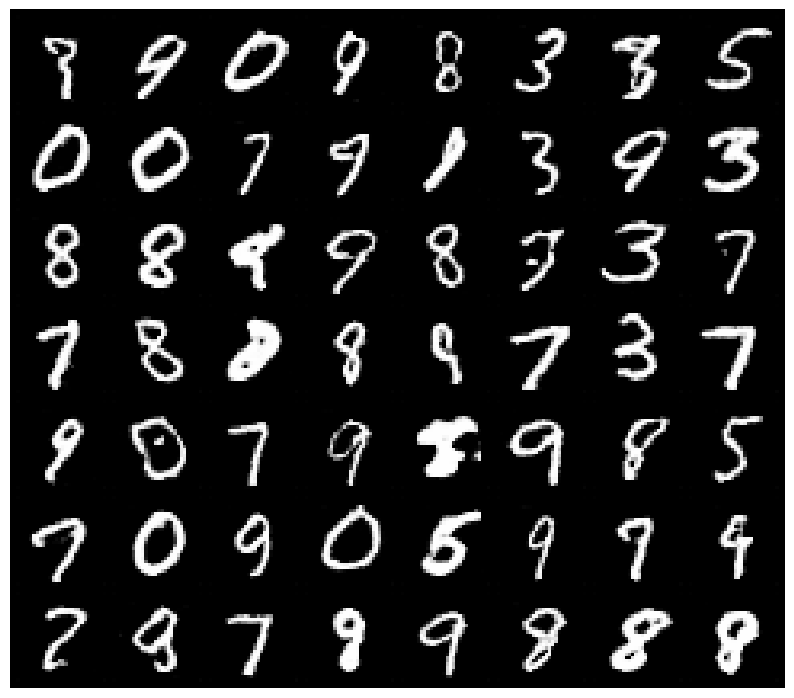

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.15it/s, loss_D=0.872, loss_G=1.52]


Epoch [128/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [128/200] - Average D loss: 0.7575, Average G loss: 1.6940


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.11it/s, loss_D=0.844, loss_G=1.7]


Epoch [129/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [129/200] - Average D loss: 0.7591, Average G loss: 1.6949


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 30.99it/s, loss_D=0.776, loss_G=1.64]


Epoch [130/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [130/200] - Average D loss: 0.7594, Average G loss: 1.6934


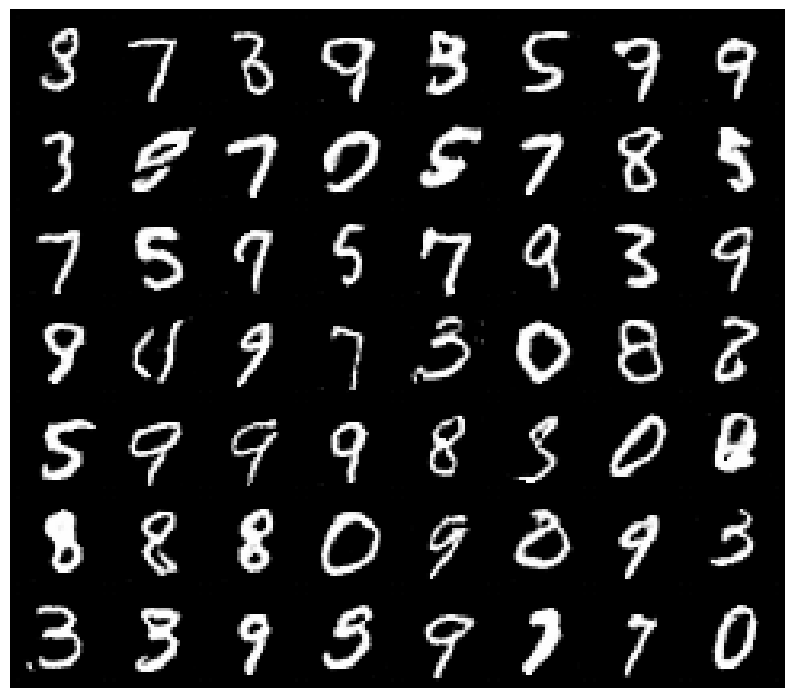

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.01it/s, loss_D=0.688, loss_G=1.85]


Epoch [131/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [131/200] - Average D loss: 0.7549, Average G loss: 1.7022


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 30.72it/s, loss_D=0.655, loss_G=1.78]


Epoch [132/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [132/200] - Average D loss: 0.7551, Average G loss: 1.7042


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 30.86it/s, loss_D=0.768, loss_G=1.67]


Epoch [133/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [133/200] - Average D loss: 0.7581, Average G loss: 1.6914


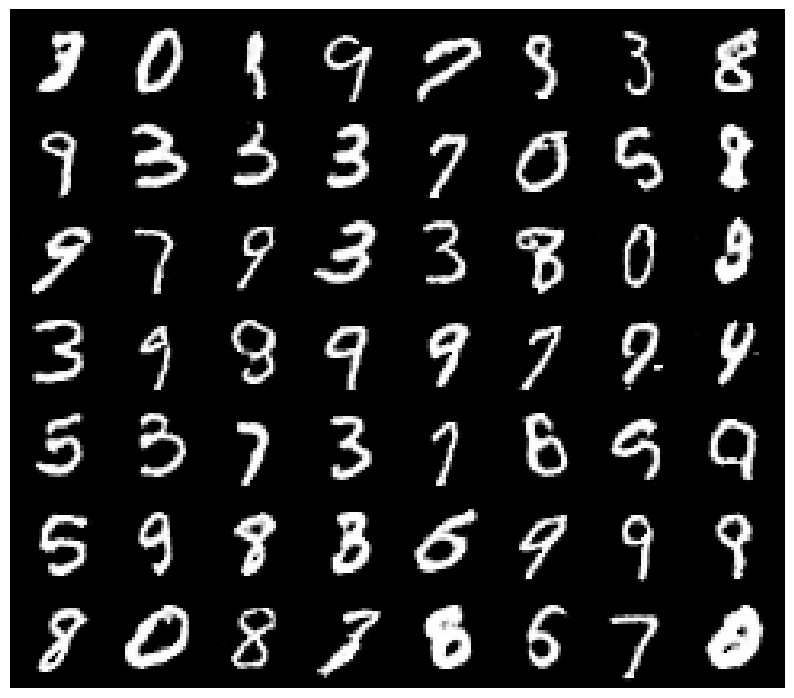

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.04it/s, loss_D=0.738, loss_G=1.76]


Epoch [134/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [134/200] - Average D loss: 0.7534, Average G loss: 1.6996


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.03it/s, loss_D=0.772, loss_G=1.62]


Epoch [135/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [135/200] - Average D loss: 0.7573, Average G loss: 1.7071


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.04it/s, loss_D=0.757, loss_G=1.81]


Epoch [136/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [136/200] - Average D loss: 0.7628, Average G loss: 1.6918


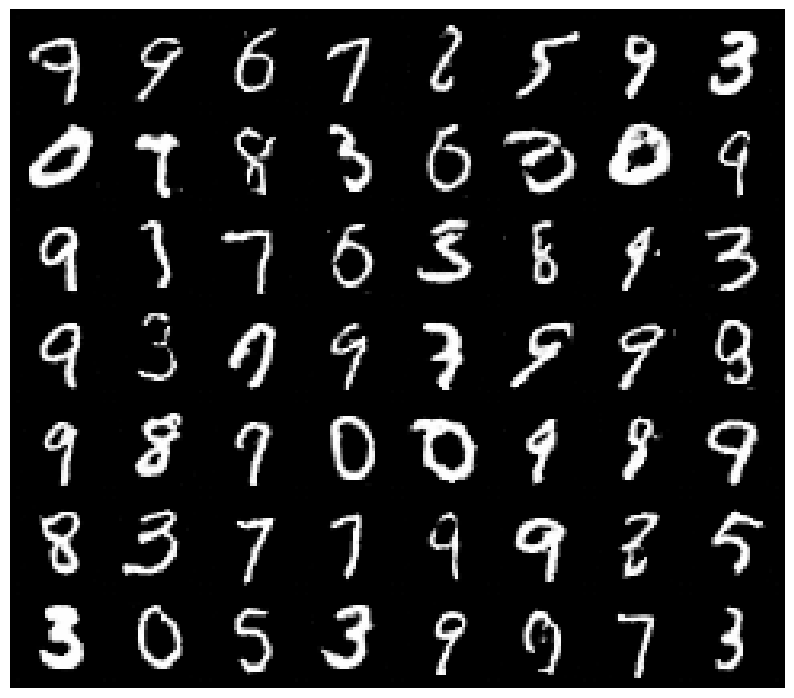

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.21it/s, loss_D=0.748, loss_G=1.56]


Epoch [137/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [137/200] - Average D loss: 0.7556, Average G loss: 1.7068


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.09it/s, loss_D=0.76, loss_G=1.51]


Epoch [138/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [138/200] - Average D loss: 0.7505, Average G loss: 1.7081


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.31it/s, loss_D=0.627, loss_G=1.75]


Epoch [139/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [139/200] - Average D loss: 0.7544, Average G loss: 1.6962


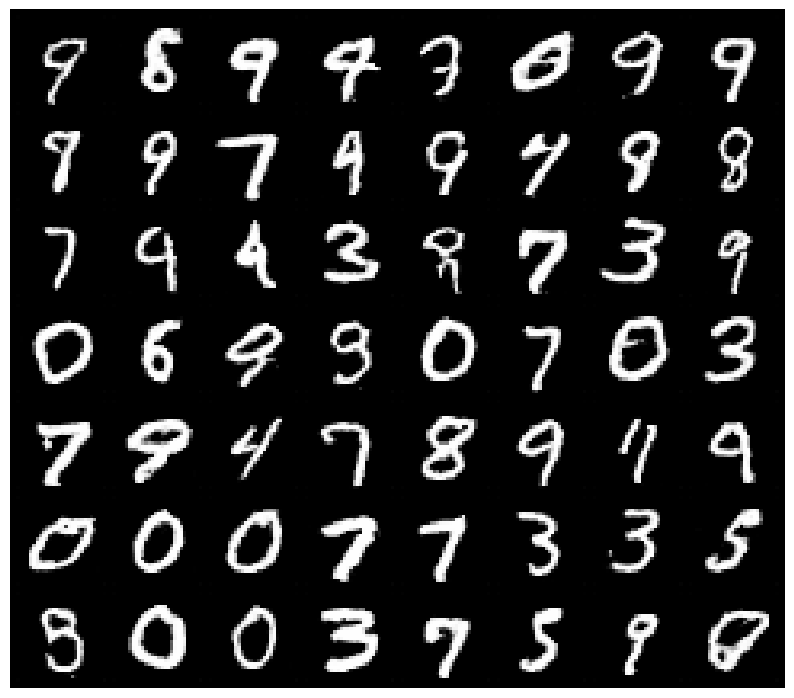

100%|██████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.63it/s, loss_D=0.671, loss_G=1.8]


Epoch [140/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [140/200] - Average D loss: 0.7571, Average G loss: 1.7053


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.11it/s, loss_D=0.757, loss_G=1.72]


Epoch [141/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [141/200] - Average D loss: 0.7521, Average G loss: 1.7029


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.05it/s, loss_D=0.956, loss_G=1.55]


Epoch [142/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [142/200] - Average D loss: 0.7539, Average G loss: 1.7603


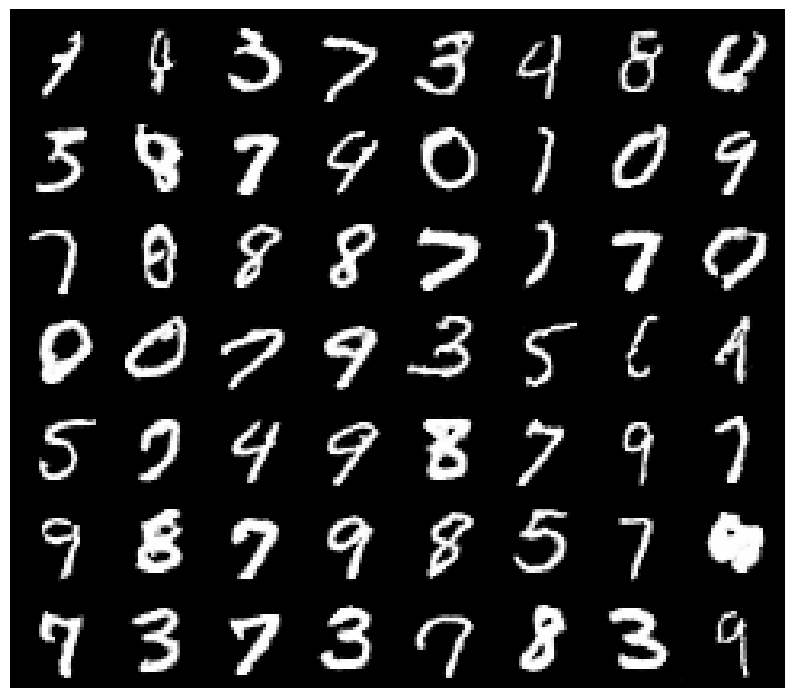

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.02it/s, loss_D=0.587, loss_G=1.95]


Epoch [143/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [143/200] - Average D loss: 0.7551, Average G loss: 1.6913


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.80it/s, loss_D=0.856, loss_G=1.63]


Epoch [144/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [144/200] - Average D loss: 0.7544, Average G loss: 1.6938


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.06it/s, loss_D=0.824, loss_G=1.53]


Epoch [145/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [145/200] - Average D loss: 0.7492, Average G loss: 1.6997


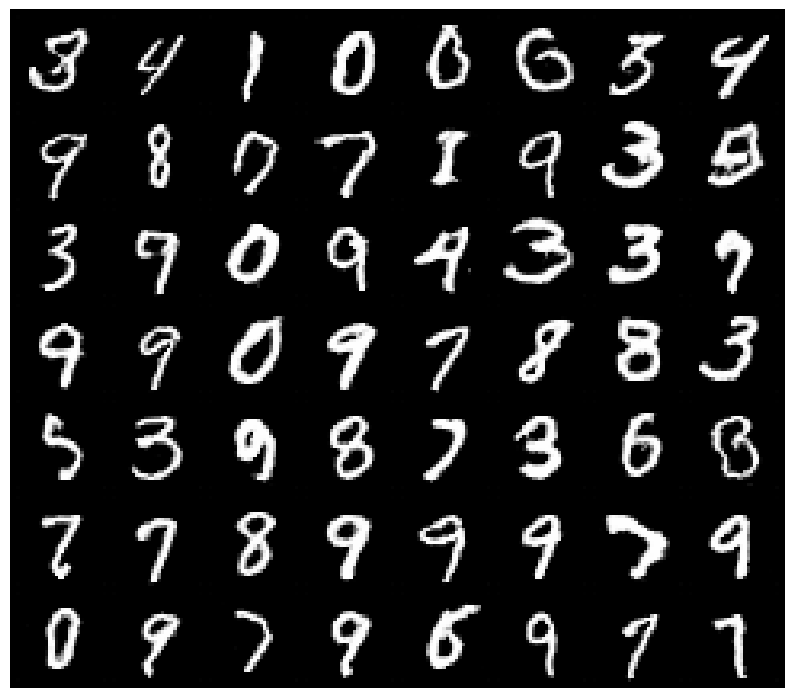

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.04it/s, loss_D=0.617, loss_G=1.73]


Epoch [146/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [146/200] - Average D loss: 0.7474, Average G loss: 1.7096


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.08it/s, loss_D=0.699, loss_G=1.48]


Epoch [147/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [147/200] - Average D loss: 0.7507, Average G loss: 1.7062


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.01it/s, loss_D=0.577, loss_G=1.98]


Epoch [148/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [148/200] - Average D loss: 0.7540, Average G loss: 1.7011


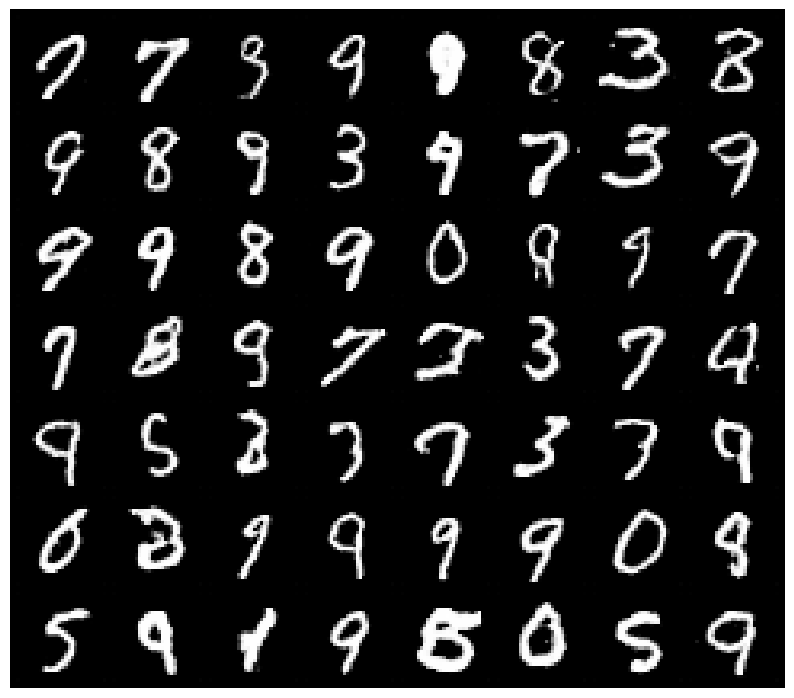

100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 30.51it/s, loss_D=0.774, loss_G=1.63]


Epoch [149/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [149/200] - Average D loss: 0.7480, Average G loss: 1.7098


100%|█████████████████████████████████████████████████████| 732/732 [00:23<00:00, 31.71it/s, loss_D=0.734, loss_G=1.75]


Epoch [150/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [150/200] - Average D loss: 0.7479, Average G loss: 1.7139


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.40it/s, loss_D=0.647, loss_G=1.66]


Epoch [151/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [151/200] - Average D loss: 0.7461, Average G loss: 1.7155


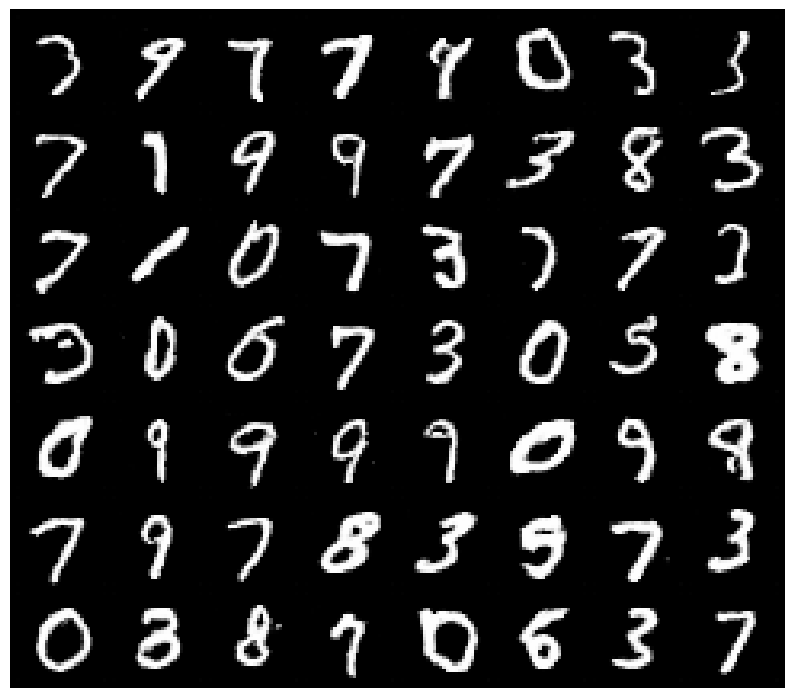

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.00it/s, loss_D=0.834, loss_G=1.67]


Epoch [152/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [152/200] - Average D loss: 0.7509, Average G loss: 1.7029


100%|█████████████████████████████████████████████████████| 732/732 [00:24<00:00, 29.74it/s, loss_D=0.669, loss_G=1.65]


Epoch [153/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [153/200] - Average D loss: 0.7504, Average G loss: 1.6996


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.20it/s, loss_D=0.801, loss_G=1.6]


Epoch [154/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [154/200] - Average D loss: 0.7498, Average G loss: 1.7029


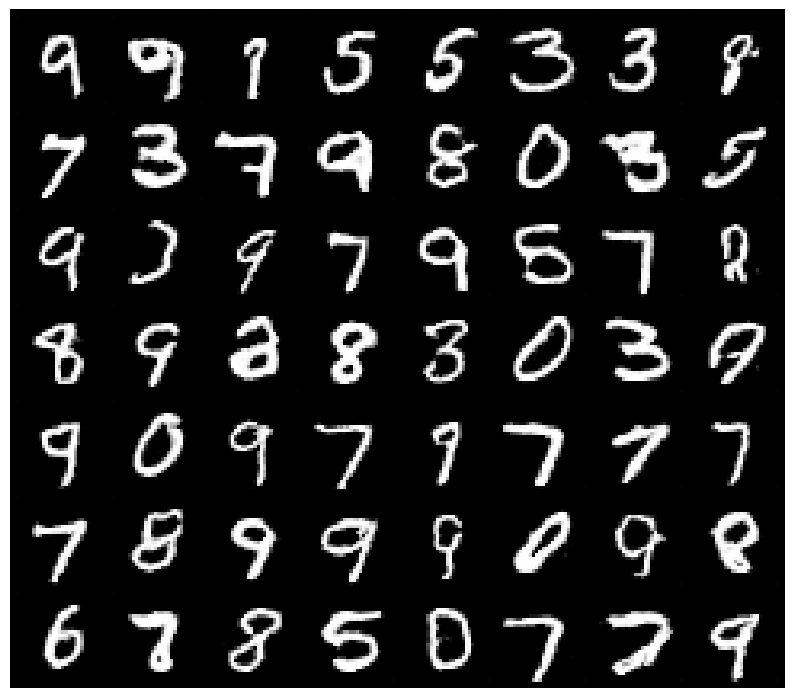

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.53it/s, loss_D=0.732, loss_G=1.69]


Epoch [155/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [155/200] - Average D loss: 0.7478, Average G loss: 1.7057


100%|██████████████████████████████████████████████████████| 732/732 [00:23<00:00, 30.69it/s, loss_D=0.75, loss_G=1.43]


Epoch [156/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [156/200] - Average D loss: 0.7521, Average G loss: 1.7101


100%|█████████████████████████████████████████████████████| 732/732 [00:50<00:00, 14.61it/s, loss_D=0.869, loss_G=1.78]


Epoch [157/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [157/200] - Average D loss: 0.7526, Average G loss: 1.7026


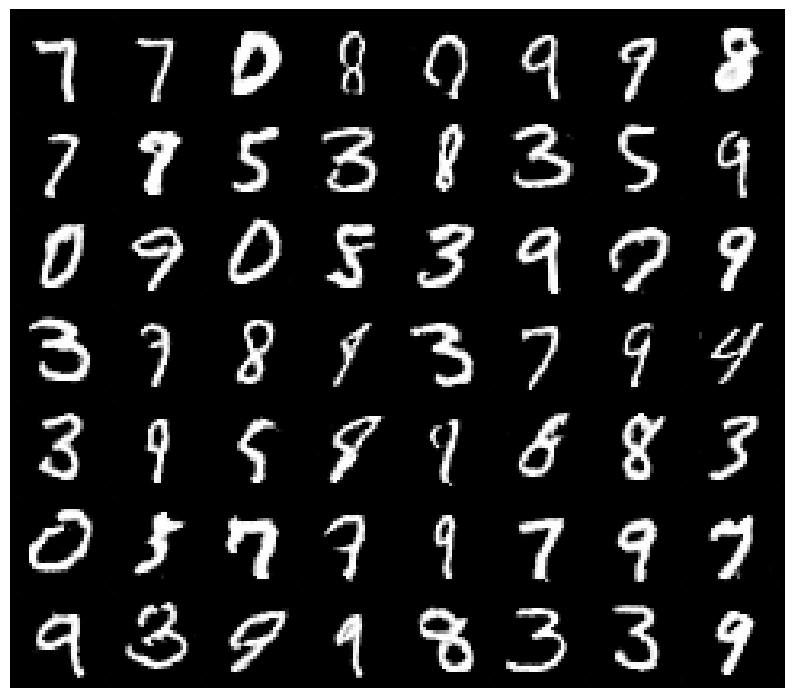

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.18it/s, loss_D=0.764, loss_G=1.61]


Epoch [158/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [158/200] - Average D loss: 0.7489, Average G loss: 1.7157


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.87it/s, loss_D=0.736, loss_G=1.75]


Epoch [159/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [159/200] - Average D loss: 0.7493, Average G loss: 1.7075


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.733, loss_G=1.43]


Epoch [160/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [160/200] - Average D loss: 0.7501, Average G loss: 1.7150


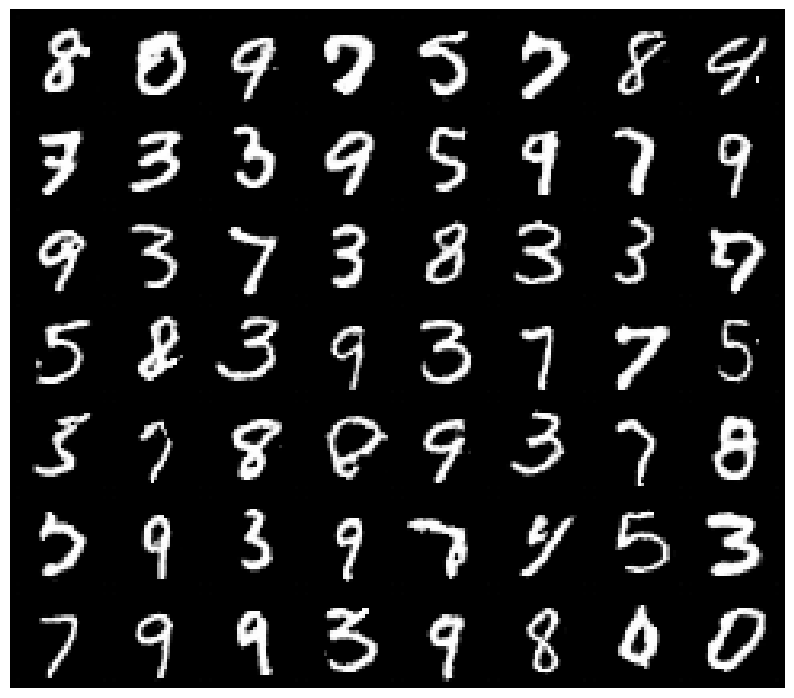

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.56, loss_G=1.87]


Epoch [161/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [161/200] - Average D loss: 0.7468, Average G loss: 1.7114


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.927, loss_G=1.66]


Epoch [162/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [162/200] - Average D loss: 0.7507, Average G loss: 1.7072


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.97it/s, loss_D=0.743, loss_G=1.88]


Epoch [163/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [163/200] - Average D loss: 0.7505, Average G loss: 1.7050


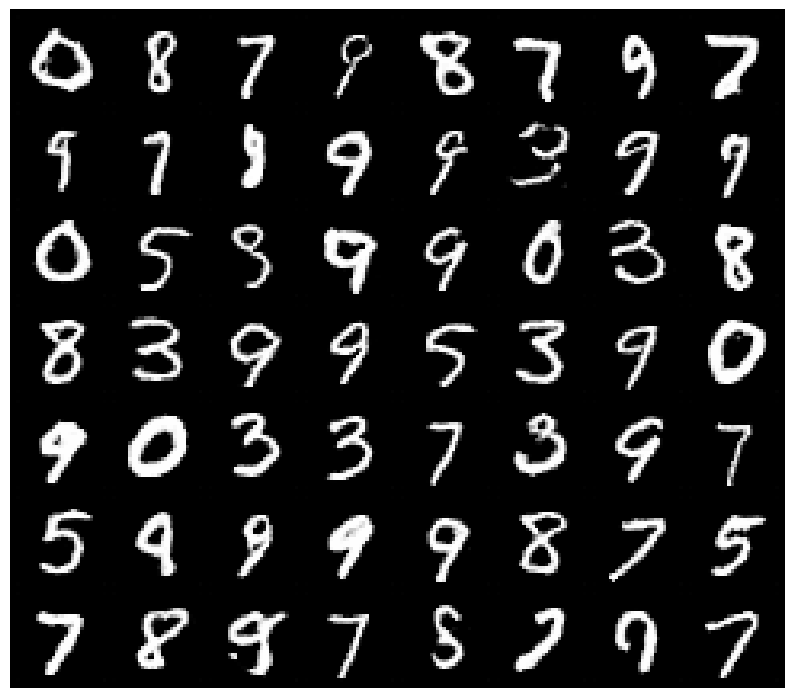

100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.79, loss_G=1.53]


Epoch [164/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [164/200] - Average D loss: 0.7545, Average G loss: 1.6953


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.01it/s, loss_D=0.955, loss_G=1.59]


Epoch [165/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [165/200] - Average D loss: 0.7531, Average G loss: 1.6953


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.12it/s, loss_D=0.858, loss_G=1.52]


Epoch [166/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [166/200] - Average D loss: 0.7544, Average G loss: 1.7100


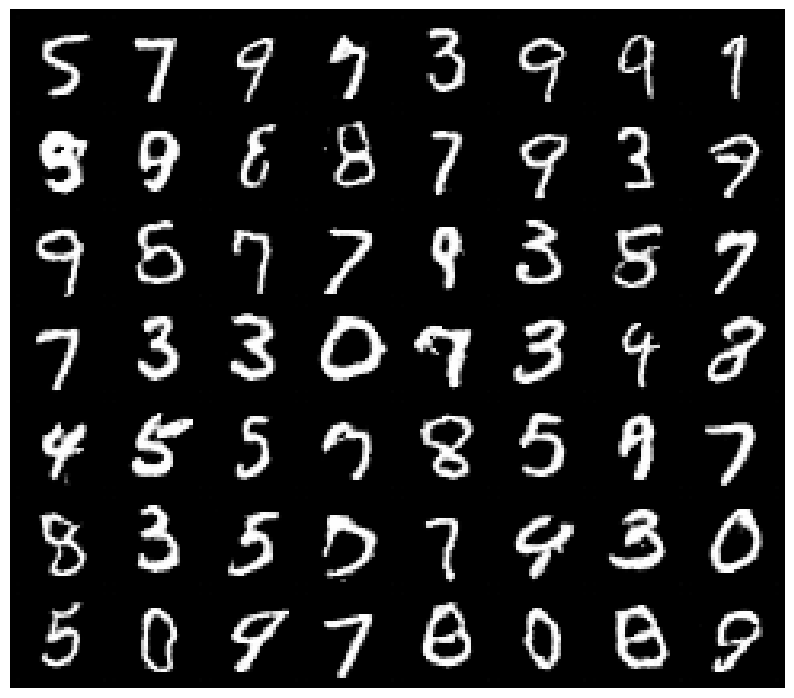

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.707, loss_G=1.71]


Epoch [167/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [167/200] - Average D loss: 0.7503, Average G loss: 1.7095


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.73it/s, loss_D=0.785, loss_G=1.67]


Epoch [168/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [168/200] - Average D loss: 0.7499, Average G loss: 1.7061


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.05it/s, loss_D=0.847, loss_G=1.76]


Epoch [169/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [169/200] - Average D loss: 0.7494, Average G loss: 1.7013


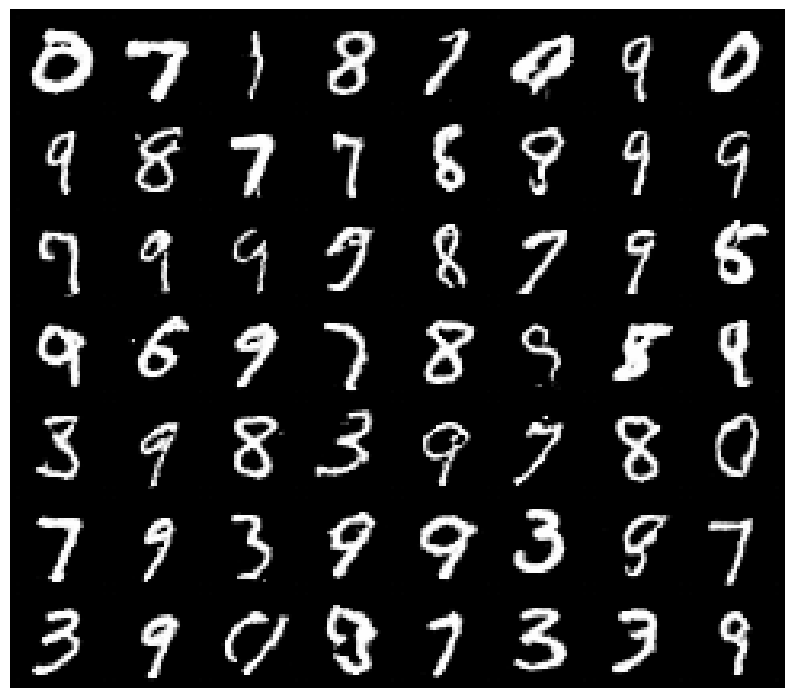

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.78it/s, loss_D=0.814, loss_G=1.63]


Epoch [170/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [170/200] - Average D loss: 0.7522, Average G loss: 1.7155


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.85it/s, loss_D=0.663, loss_G=1.95]


Epoch [171/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [171/200] - Average D loss: 0.7549, Average G loss: 1.6950


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.913, loss_G=1.51]


Epoch [172/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [172/200] - Average D loss: 0.7504, Average G loss: 1.7000


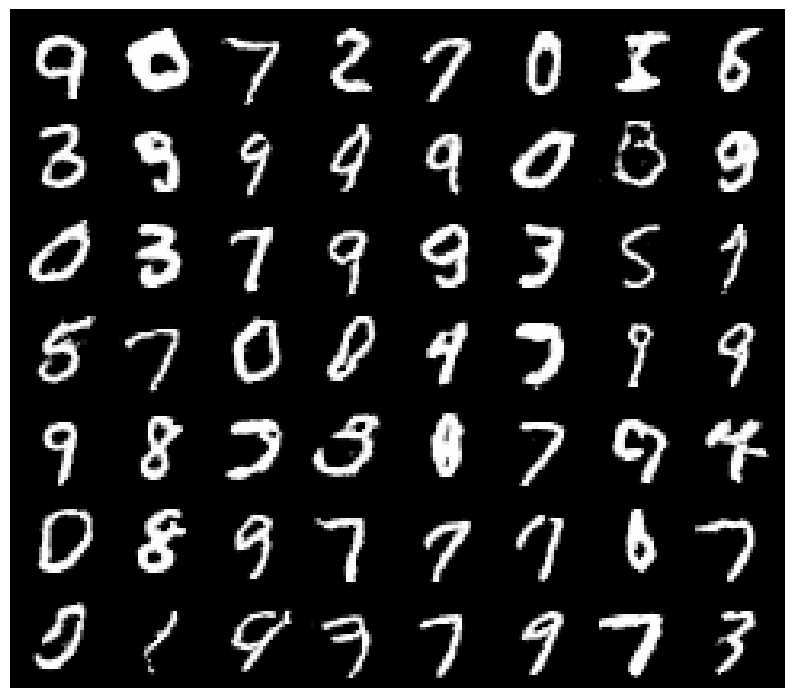

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.714, loss_G=2.01]


Epoch [173/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [173/200] - Average D loss: 0.7561, Average G loss: 1.6979


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.764, loss_G=1.8]


Epoch [174/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [174/200] - Average D loss: 0.7512, Average G loss: 1.7046


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.86it/s, loss_D=0.797, loss_G=1.66]


Epoch [175/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [175/200] - Average D loss: 0.7522, Average G loss: 1.7013


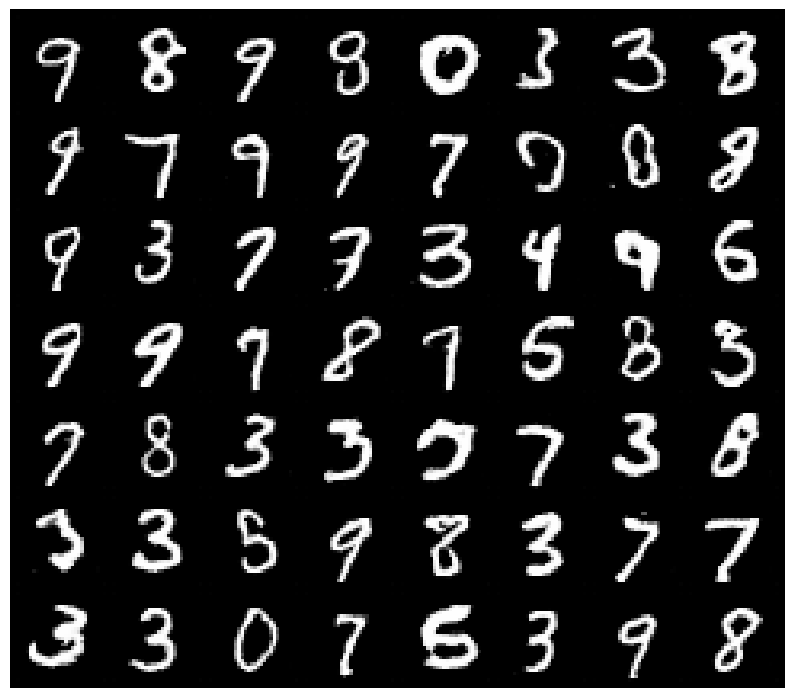

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.732, loss_G=1.62]


Epoch [176/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [176/200] - Average D loss: 0.7500, Average G loss: 1.7031


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.15it/s, loss_D=0.625, loss_G=1.84]


Epoch [177/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [177/200] - Average D loss: 0.7481, Average G loss: 1.7104


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.99it/s, loss_D=0.62, loss_G=1.61]


Epoch [178/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [178/200] - Average D loss: 0.7518, Average G loss: 1.7088


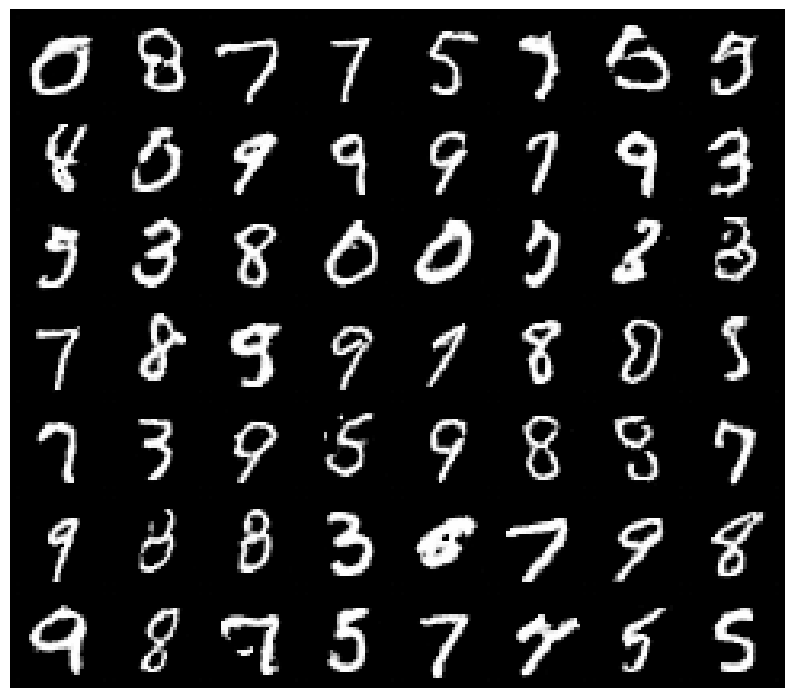

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.846, loss_G=1.71]


Epoch [179/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [179/200] - Average D loss: 0.7474, Average G loss: 1.7095


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.77, loss_G=1.76]


Epoch [180/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [180/200] - Average D loss: 0.7485, Average G loss: 1.6967


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.77it/s, loss_D=0.862, loss_G=1.66]


Epoch [181/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [181/200] - Average D loss: 0.7501, Average G loss: 1.6945


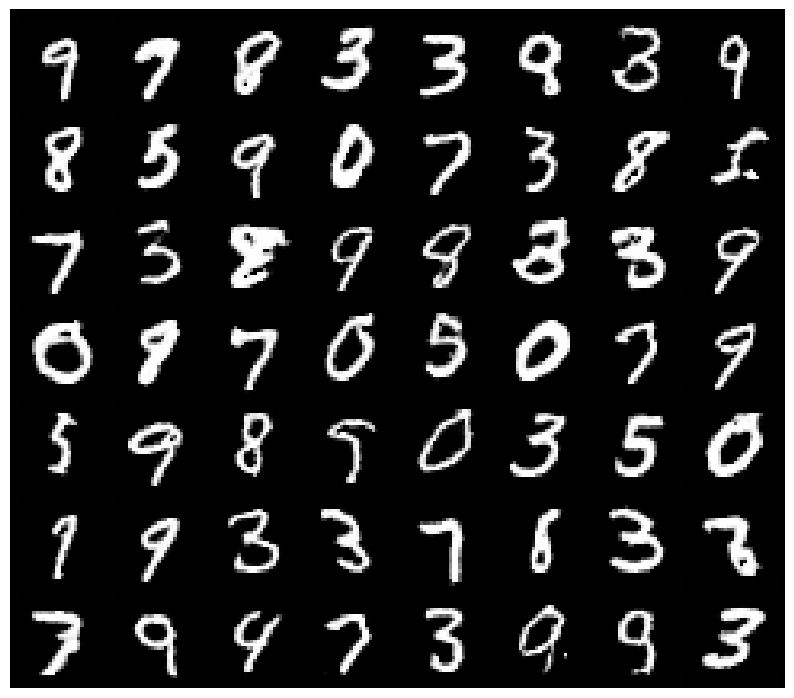

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.03it/s, loss_D=0.737, loss_G=1.61]


Epoch [182/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [182/200] - Average D loss: 0.7519, Average G loss: 1.6915


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.82it/s, loss_D=0.795, loss_G=1.64]


Epoch [183/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [183/200] - Average D loss: 0.7542, Average G loss: 1.7186


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.792, loss_G=1.84]


Epoch [184/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [184/200] - Average D loss: 0.7538, Average G loss: 1.6942


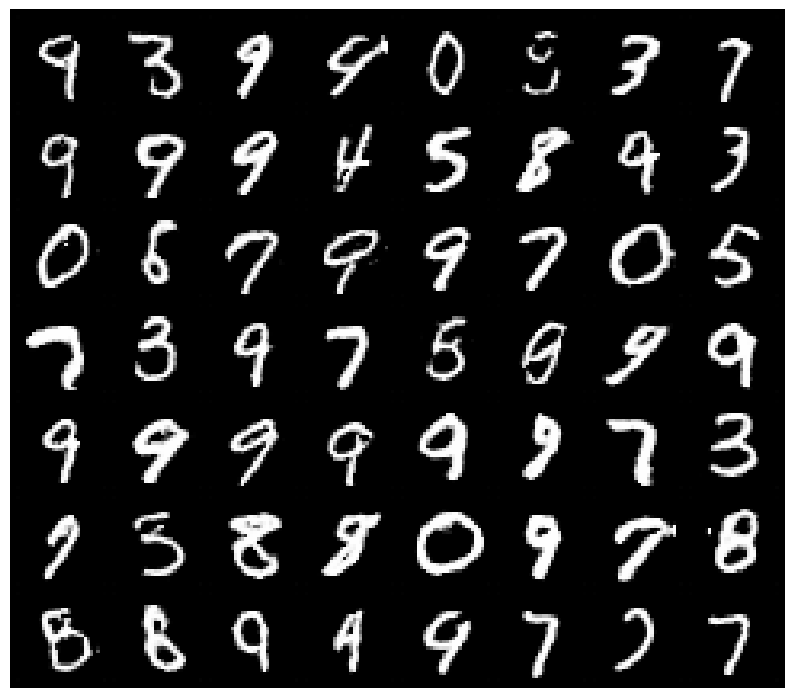

100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.661, loss_G=1.85]


Epoch [185/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [185/200] - Average D loss: 0.7519, Average G loss: 1.6955


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.98it/s, loss_D=0.671, loss_G=1.67]


Epoch [186/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [186/200] - Average D loss: 0.7507, Average G loss: 1.7049


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.90it/s, loss_D=0.826, loss_G=1.5]


Epoch [187/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [187/200] - Average D loss: 0.7481, Average G loss: 1.7067


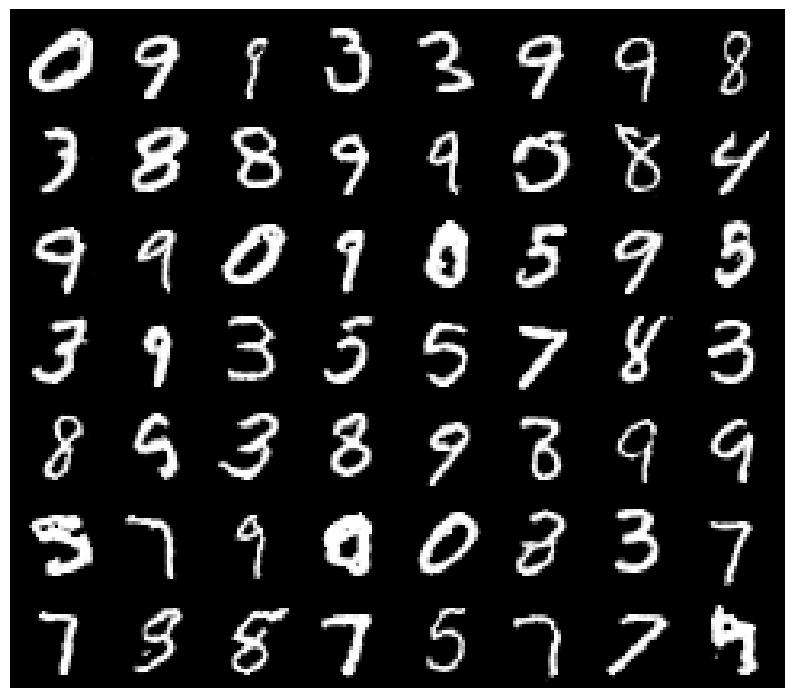

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.00it/s, loss_D=0.666, loss_G=1.86]


Epoch [188/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [188/200] - Average D loss: 0.7495, Average G loss: 1.7031


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.68it/s, loss_D=0.737, loss_G=1.76]


Epoch [189/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [189/200] - Average D loss: 0.7482, Average G loss: 1.6997


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.92it/s, loss_D=0.612, loss_G=1.68]


Epoch [190/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [190/200] - Average D loss: 0.7573, Average G loss: 1.6984


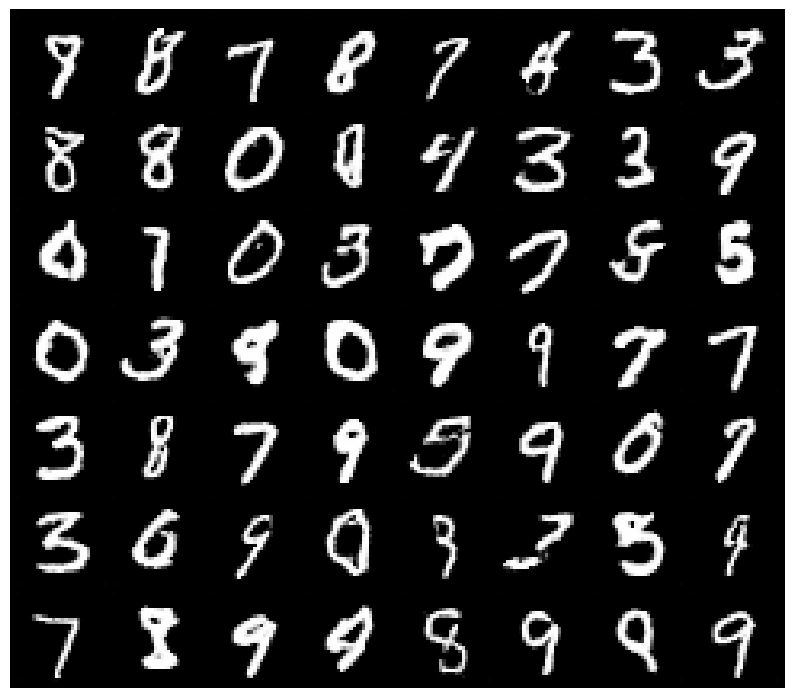

100%|███████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.94it/s, loss_D=0.7, loss_G=1.84]


Epoch [191/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [191/200] - Average D loss: 0.7497, Average G loss: 1.7039


100%|███████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.13it/s, loss_D=0.94, loss_G=1.8]


Epoch [192/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [192/200] - Average D loss: 0.7520, Average G loss: 1.7057


100%|█████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.79it/s, loss_D=0.633, loss_G=1.77]


Epoch [193/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [193/200] - Average D loss: 0.7508, Average G loss: 1.7013


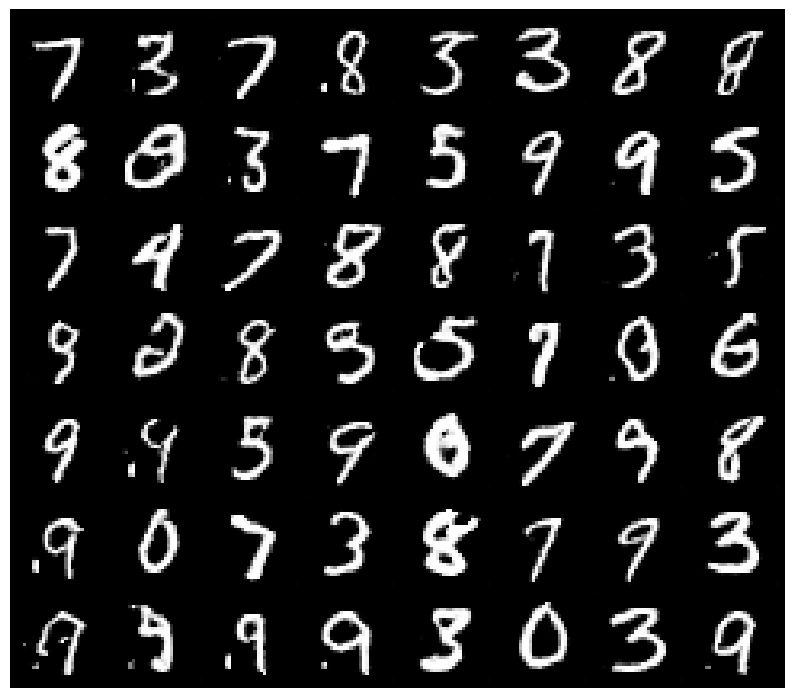

100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.10it/s, loss_D=0.596, loss_G=1.68]


Epoch [194/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [194/200] - Average D loss: 0.7490, Average G loss: 1.7020


100%|██████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.91it/s, loss_D=0.782, loss_G=1.5]


Epoch [195/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [195/200] - Average D loss: 0.7489, Average G loss: 1.6934


100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 13.93it/s, loss_D=0.914, loss_G=1.88]


Epoch [196/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [196/200] - Average D loss: 0.7457, Average G loss: 1.7093


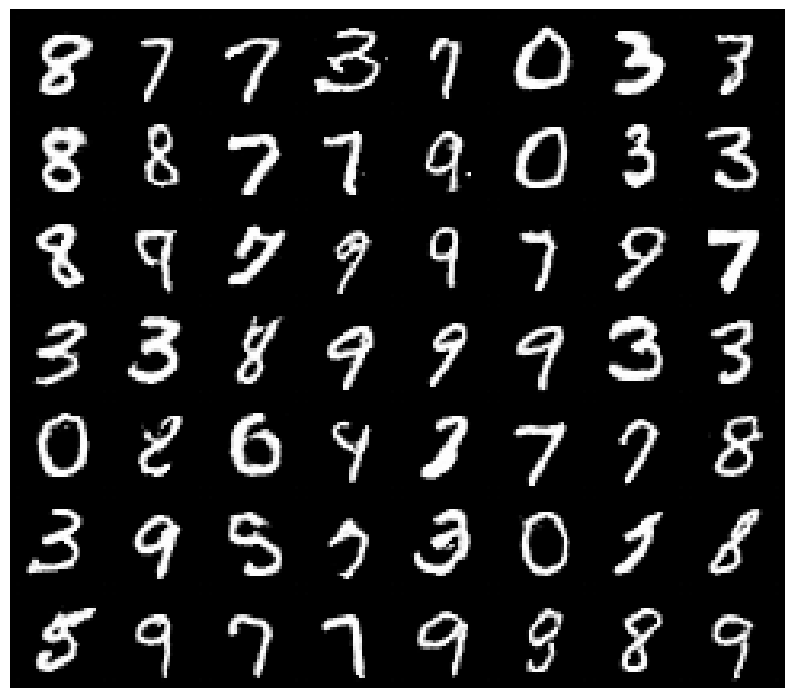

100%|█████████████████████████████████████████████████████| 732/732 [00:52<00:00, 14.07it/s, loss_D=0.873, loss_G=1.66]


Epoch [197/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [197/200] - Average D loss: 0.7500, Average G loss: 1.7082


100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.80it/s, loss_D=1.18, loss_G=1.72]


Epoch [198/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [198/200] - Average D loss: 0.7484, Average G loss: 1.7002


100%|█████████████████████████████████████████████████████| 732/732 [00:51<00:00, 14.11it/s, loss_D=0.765, loss_G=1.64]


Epoch [199/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [199/200] - Average D loss: 0.7522, Average G loss: 1.7043


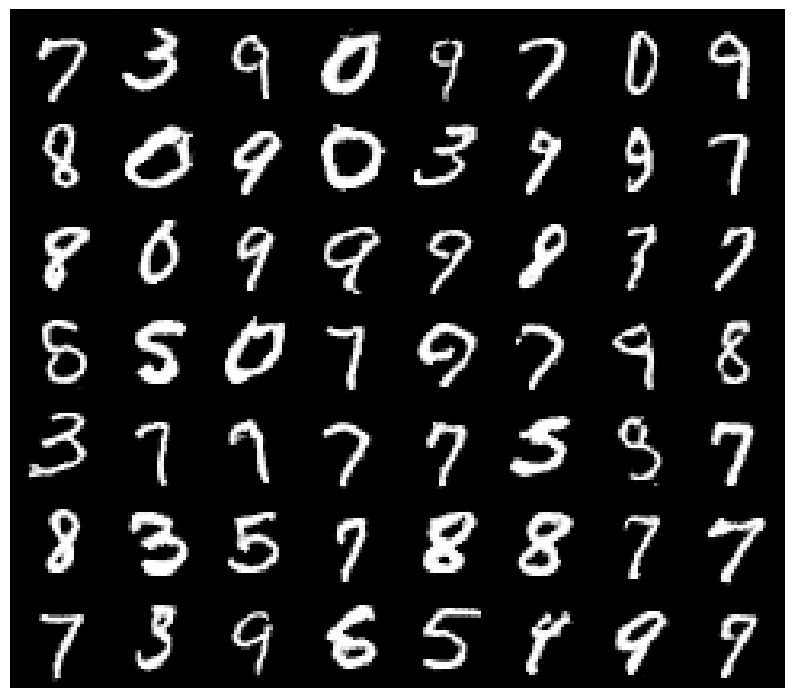

100%|██████████████████████████████████████████████████████| 732/732 [00:53<00:00, 13.72it/s, loss_D=0.671, loss_G=1.6]


Epoch [200/200] - LR G: 0.0000110, LR D: 0.0000110
Epoch [200/200] - Average D loss: 0.7521, Average G loss: 1.7012


In [15]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 200
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

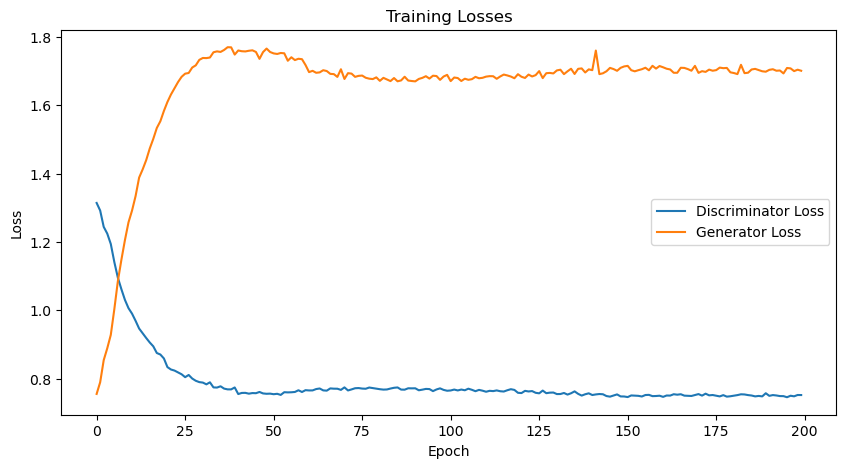

In [16]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [18]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [19]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

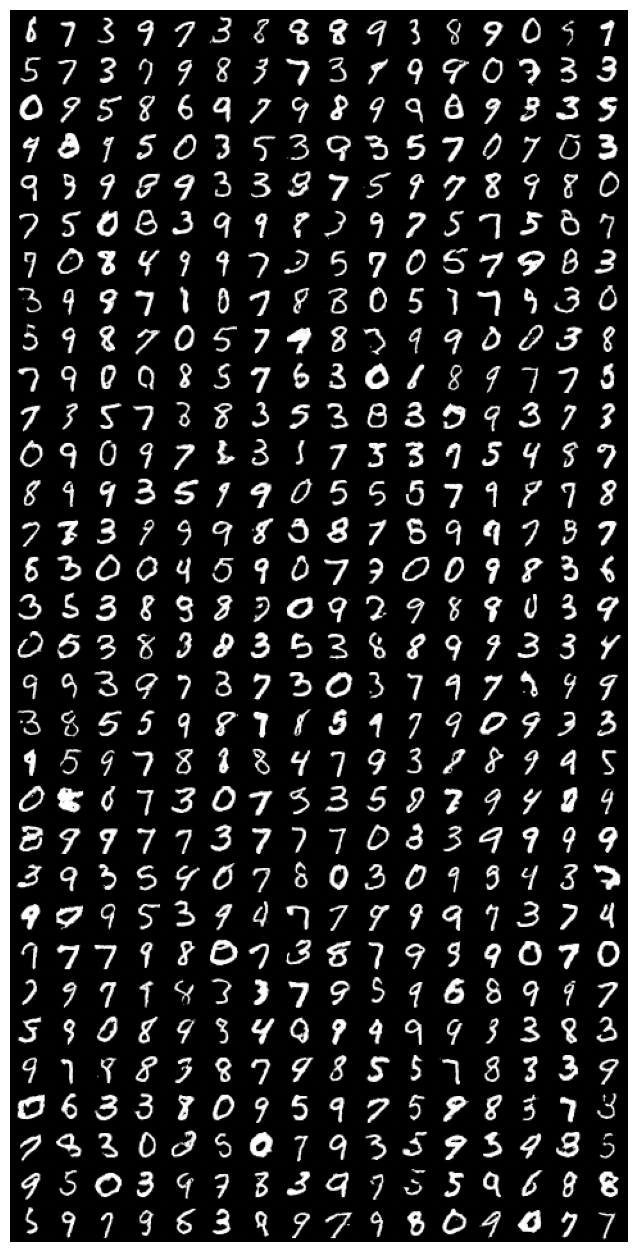

In [24]:
# Generate noise vectors
batch_size = 512  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(16, 16))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
